In [1]:
# import packages
import warnings
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import sys
import time
import random
import dill
from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance
from datetime import timedelta

from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Reshape

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')


In [2]:
df_month = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Month per case basis .csv', index_col=False)
df_hour = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False)


In [3]:
df_month.head()


Year     Month  Damage to Property  Fatal  Non Fatal Injury  Grand Total
0  2018   January                2743      7               403         3153
1  2018  February                2621      7               423         3051
2  2018     March                2711     12               475         3198
3  2018     April                2573      7               417         2997
4  2018       May                2721     10               432         3163

In [4]:
df_hour.head()

Year    Time Hour  Damage to Property  Fatal  Non Fatal Injury  Grand Total
0  2018  00:00-00:59                 599    3.0               162          764
1  2018  01:00-01:59                 551    8.0               132          691
2  2018  02:00-02:59                 469    7.0               130          606
3  2018  03:00-03:59                 449   12.0               128          589
4  2018  04:00-04:59                 565   12.0               140          717

In [5]:
DEPENDENT_VARIABLE = "Grand Total"

In [6]:
df_month[DEPENDENT_VARIABLE] = df_month[DEPENDENT_VARIABLE].fillna(0)
df_month[DEPENDENT_VARIABLE] = df_month[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' '
    else float(
        str(x).replace(',', '').replace('', ''))
)


In [7]:
df_hour[DEPENDENT_VARIABLE] = df_hour[DEPENDENT_VARIABLE].fillna(0)
df_hour[DEPENDENT_VARIABLE] = df_hour[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' '
    else float(
        str(x).replace(',', '').replace('', ''))
)


In [8]:
df_month.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                60 non-null     int64  
 1   Month               60 non-null     object 
 2   Damage to Property  60 non-null     int64  
 3   Fatal               60 non-null     int64  
 4   Non Fatal Injury    60 non-null     int64  
 5   Grand Total         60 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.9+ KB


In [9]:
df_hour.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                125 non-null    int64  
 1   Time Hour           125 non-null    object 
 2   Damage to Property  125 non-null    int64  
 3   Fatal               121 non-null    float64
 4   Non Fatal Injury    125 non-null    int64  
 5   Grand Total         125 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 6.0+ KB


In [10]:
df_month.describe()


Year  Damage to Property      Fatal  Non Fatal Injury  \
count    60.000000           60.000000  60.000000         60.000000   
mean   2020.000000         2012.816667   9.400000        460.300000   
std       1.426148          735.276738   3.092912         83.087314   
min    2018.000000          249.000000   1.000000        164.000000   
25%    2019.000000         1444.250000   7.000000        416.500000   
50%    2020.000000         1834.500000  10.000000        456.500000   
75%    2021.000000         2725.750000  11.000000        518.000000   
max    2022.000000         3162.000000  18.000000        648.000000   

       Grand Total  
count    60.000000  
mean   2482.516667  
std     777.578063  
min     414.000000  
25%    1842.500000  
50%    2348.000000  
75%    3186.750000  
max    3711.000000

In [11]:
df_hour.describe()


Year  Damage to Property       Fatal  Non Fatal Injury  \
count   125.000000          125.000000  121.000000        125.000000   
mean   2020.000000          966.152000    4.661157        220.944000   
std       1.419905          561.889354    2.706639         82.841697   
min    2018.000000           13.000000    1.000000         10.000000   
25%    2019.000000          481.000000    3.000000        166.000000   
50%    2020.000000         1004.000000    4.000000        239.000000   
75%    2021.000000         1283.000000    6.000000        275.000000   
max    2022.000000         2095.000000   14.000000        420.000000   

       Grand Total  
count   125.000000  
mean   1191.608000  
std     621.695223  
min      25.000000  
25%     674.000000  
50%    1262.000000  
75%    1508.000000  
max    2384.000000

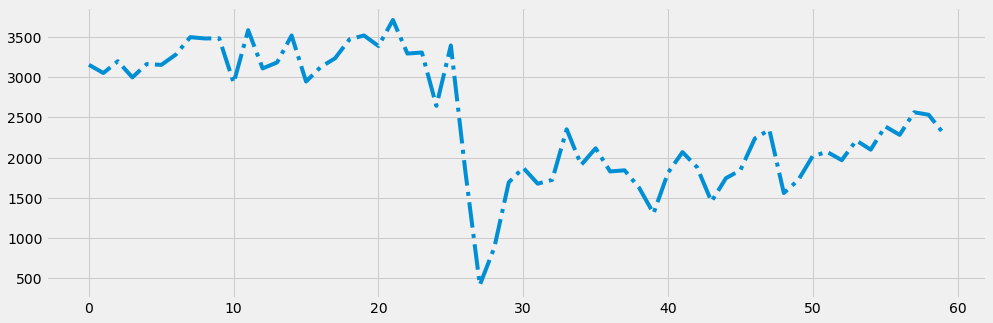

In [12]:
df_month[DEPENDENT_VARIABLE].plot(style='-.',figsize=(15, 5))
plt.show()


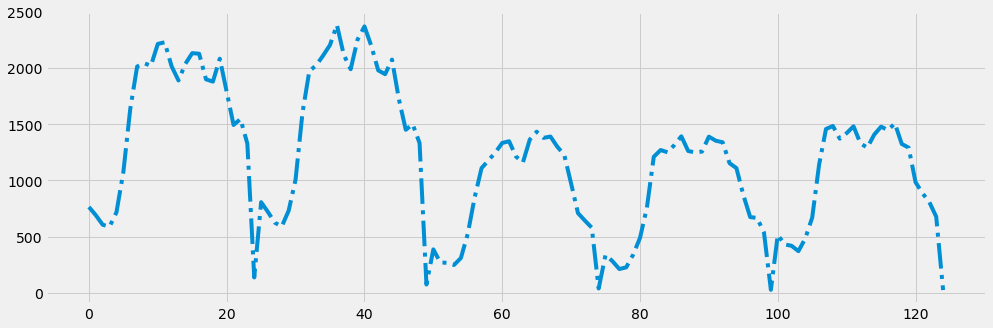

In [13]:
df_hour[DEPENDENT_VARIABLE].plot(style='-.', figsize=(15, 5),)
plt.show()

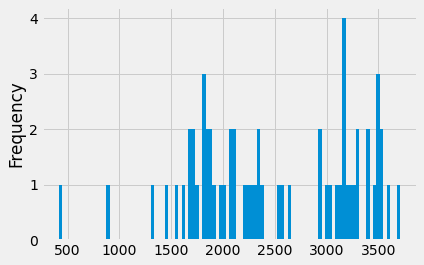

In [14]:
df_month[DEPENDENT_VARIABLE].plot(kind='hist', bins=100);

<AxesSubplot:ylabel='Frequency'>

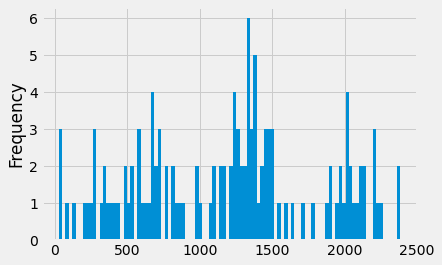

In [15]:
df_hour[DEPENDENT_VARIABLE].plot(kind='hist', bins=100)


In [16]:
from dateutil.relativedelta import relativedelta, MO
dtime_day = {
    "00:00-00:59": "Night",
    "01:00-01:59": "Night",
    "02:00-02:59": "Night",
    "03:00-03:59": "Night",
    "04:00-04:59": "Night",
    "05:00-05:59": "Morning",
    "06:00-06:59": "Morning",
    "07:00-07:59": "Morning",
    "08:00-08:59": "Morning",
    "09:00-09:59": "Morning",
    "10:00-10:59": "Morning",
    "11:00-11:59": "Morning",
    "12:00-12:59": "Afternoon",
    "13:00-13:59": "Afternoon",
    "14:00-14:59": "Afternoon",
    "15:00-15:59": "Afternoon",
    "16:00-16:59": "Afternoon",
    "17:00-17:59": "Afternoon",
    "18:00-18:59": "Evening",
    "19:00-19:59": "Evening",
    "20:00-20:59": "Night",
    "21:00-21:59": "Night",
    "22:00-22:59": "Night",
    "23:00-23:59": "Night",
    "Time Not Stated": "unkown",
}

# 0 - Not rush hour
# 1 - Rush hour
'''
Worst traffic is at 7AM to 9AM and on 5PM to 9PM
Medium traffic is at 9AM to 10AM and on 9PM to 11PM
Low Traffic rest of the Hour
'''
rush_hour = {
    "00:00-00:59":  "Low",
    "01:00-01:59":  "Low",
    "02:00-02:59": "Low",
    "03:00-03:59": "Low",
    "04:00-04:59": "Low",
    "05:00-05:59": "Low",
    "06:00-06:59": "Low",
    "07:00-07:59": "High",
    "08:00-08:59": "High",
    "09:00-09:59": "Medium",
    "10:00-10:59": "Low",
    "11:00-11:59": "Low",
    "12:00-12:59": "Low",
    "13:00-13:59": "Low",
    "14:00-14:59": "Low",
    "15:00-15:59": "Low",
    "16:00-16:59": "Low",
    "17:00-17:59": "High",
    "18:00-18:59": "High",
    "19:00-19:59": "High",
    "20:00-20:59": "High",
    "21:00-21:59": "Medium",
    "22:00-22:59": "Medium",
    "23:00-23:59": "Medium",
    "Time Not Stated": "Neutral",
}


def create_features_monthly(df, target_variable):
    df['Year'] = df['Year'].apply(lambda x: int(x))
    X = df[[
        'Year', 'Month', DEPENDENT_VARIABLE
    ]]
    X = pd.get_dummies(X, columns=['Month'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X


def create_features_hourly(df, target_variable):
    def hourmin_decimal(time, index):
        if time == 'Time Not Stated':
            return -1
        time = time.split('-')[index].split(':')
        hour = int(time[0])
        minutes = int(time[-1])
        return int(hour) * 3600 + int(minutes) * 60

    df['Year'] = df['Year'].apply(lambda x: int(x))
    df['Day Time'] = df['Time Hour'].apply(lambda x:  dtime_day[x])
    df['Hour Start'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x, 0))
    df['Hour End'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x, -1))
    df['Traffic'] = df['Time Hour'].apply(lambda x: rush_hour[x])
    X = df[[
        'Year', 'Day Time', 'Hour Start', 'Hour End', 'Traffic', DEPENDENT_VARIABLE
    ]]
    X = pd.get_dummies(X, columns=['Day Time', 'Traffic'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X


def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape


def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''
    # print('Evaluation metric results: ')
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error_func(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    return {"mse": mse, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}, [mse, mae, rmse, mape, r2 ]


def dataframe_splitter(arr, indexes_range):
    result = [[] for i in range(indexes_range)]
    for i in range(indexes_range):
        result[i] = [j[i] for j in arr]
    return result


def time_series_split(data_frame, target_column_name, n_splits=7):
    X = data_frame.drop(target_column_name, axis=1)
    y = data_frame[target_column_name]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    train_test_sets = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        train_test_sets.append((X_train, y_train, X_test, y_test))

    return train_test_sets


def time_based_split(data, train_pct):
    train_size = int(len(data) * train_pct)
    train, test = data[:train_size], data[train_size:]
    return train, test

def print_values_metrics(model_name, metric_dict):
  printed_metrics = ''.join(
      [f' ({i}: {round(metric_dict[i], 4):,})\t' for i in metric_dict])
  print(f"{printed_metrics}: {model_name}")


In [17]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge,
                                  OrthogonalMatchingPursuit, ARDRegression, LogisticRegression,
                                  PoissonRegressor, GammaRegressor, TweedieRegressor, PassiveAggressiveRegressor,
                                  RANSACRegressor, TheilSenRegressor, HuberRegressor)



from sklearn.svm import (SVR, NuSVR, LinearSVR)
from sklearn.tree import (DecisionTreeRegressor)
from sklearn.ensemble import (ExtraTreesRegressor, AdaBoostRegressor,
                              GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor)
from sklearn.neighbors import (RadiusNeighborsRegressor)
from sklearn.neural_network import (MLPRegressor)
from sklearn.gaussian_process import (GaussianProcessRegressor)
from xgboost import XGBRegressor, XGBRFRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

# LSTM custom
# LSTM + Transfer Learning


include_params = False

def linear_regression(trainX, trainY, testX):
    param_grid = {
        'fit_intercept': [True, False],
    }
    model = LinearRegression()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ridge(trainX, trainY, testX):
    param_grid = {
        'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0], 
        "fit_intercept": [True, False], 
        "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }
    model = Ridge()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def lasso(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'max_iter': [500, 1000, 2000, 5000],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False],
        'positive': [True, False],
    }
    model = Lasso()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def elastic_net(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'max_iter': [500, 1000, 2000, 5000],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False],
        'positive': [True, False],
    }
    model = ElasticNet()
    model = GridSearchCV(model, param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def bayesian_ridge(trainX, trainY, testX):
    param_grid = {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'fit_intercept': [True, False],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = BayesianRidge()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def orthogonal_matching_pursuit(trainX, trainY, testX):
    param_grid = {
        'n_nonzero_coefs': list(range(1, trainX.shape[1] + 1)),
        'fit_intercept': [True, False]
    }
    model = OrthogonalMatchingPursuit()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ard_regression(trainX, trainY, testX):
    param_grid = {
        'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
        'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3],
        'fit_intercept': [True, False],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = ARDRegression()
    model = GridSearchCV(model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def logistic_regression(trainX, trainY, testX):
    param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3]
    }
    model = LogisticRegression()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=KFold(n_splits=5))
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def poisson_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = PoissonRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gamma_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = GammaRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def tweedie_regressor(trainX, trainY, testX):
    param_grid = {
        'alpha': [0.0, 0.001, 0.01, 0.1, 1, 10],
        'power': [0, 1, 1.5, 2, 3],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = TweedieRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def passive_aggressive_regressor(trainX, trainY, testX):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'fit_intercept': [True, False],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'early_stopping': [True, False],
        'validation_fraction': [0.1, 0.2, 0.3],
        'n_iter_no_change': [5, 10, 15],
        'shuffle': [True, False],
        'warm_start': [True, False]
    }
    model = PassiveAggressiveRegressor()

    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ransac_regressor(trainX, trainY, testX):
    param_grid = {
        #'min_samples': [0.1, 0.2, 0.3, 0.4, 0.5],
        'residual_threshold': [1, 5, 10, 20],
        'max_trials': [100, 500, 1000],
        'stop_n_inliers': [50, 100, 200],
        'stop_score': [0.9, 0.95, 0.99],
        'stop_probability': [0.9, 0.95, 0.99],
        'loss': ['squared_error', 'absolute_error']
    }
    model = RANSACRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def theil_sen_regressor(trainX, trainY, testX):
    param_grid = {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'max_subpopulation': [1e4, 1e5, 1e6],
        'n_subsamples': [None, 50, 100, 200],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = TheilSenRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def huber_regressor(trainX, trainY, testX):
    param_grid = {
        'epsilon': [1.0, 1.5, 2.0],
        'fit_intercept': [True, False],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'max_iter': [50, 100, 200, 500],
        'tol': [1e-5, 1e-4, 1e-3],
        'warm_start': [True, False]
    }
    model = HuberRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def svr(trainX, trainY, testX):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10],
        'coef0': [-1, 0, 1],
        'shrinking': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = SVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour
    
def nu_svr(trainX, trainY, testX):
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10],
        'coef0': [-1, 0, 1],
        'nu': [0.1, 0.3, 0.5, 0.7, 0.9],
        'shrinking': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
    }
    model = NuSVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def linear_svr(trainX, trainY, testX):
    param_grid = {
        'epsilon': [0.01, 0.1, 1, 10],
        'C': [0.01, 0.1, 1, 10, 100],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'fit_intercept': [True, False],
        'intercept_scaling': [1, 2, 3],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
        'max_iter': [50, 100, 200, 500],
    }
    model = LinearSVR()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def decision_tree_regressor(trainX, trainY, testX):
    param_grid = {
        'criterion': ['mse', 'friedman_mse', 'mae'],
        'max_depth': [None, 5, 10, 15],
        #'min_samples_split': [2, 5, 10, 15],
        #'min_samples_leaf': [1, 2, 5, 10],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
    }
    model = DecisionTreeRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def extra_trees_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'criterion': ['mse', 'mae', 'friedman_mse', 'poisson'],
        'max_depth': [None, 5, 10, 15],
        #'min_samples_split': [2, 5, 10, 15],
        #'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
    }
    model = ExtraTreesRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def ada_boost_regressor(trainX, trainY, testX):
    param_grid = {
        'base_estimator': [DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5)],
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1, 10],
        'loss': ['linear', 'square', 'exponential']
    }
    model = AdaBoostRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gradient_boosting_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': [0.01, 0.1, 1, 10],
        'max_depth': [3, 5, 7, 9],
        #'min_samples_split': [2, 5, 10, 15],
        #'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'subsample': [0.5, 0.75, 1.0],
    }
    model = GradientBoostingRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def hist_gradient_boosting_regressor(trainX, trainY, testX):
    param_grid = {
        'learning_rate': [0.01, 0.1, 1, 10],
        'max_iter': [50, 100, 200, 500],
        'max_depth': [3, 5, 7, 9],
        'max_leaf_nodes': [None, 5, 10, 15],
        #'min_samples_leaf': [1, 2, 5, 10],
        'l2_regularization': [0.0, 0.1, 0.2],
        'max_bins': [255, 512, 1024],
        'warm_start': [True, False],
        'early_stopping': [None, 'auto', 10],
    }
    model = HistGradientBoostingRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def random_forest_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200, 500],
        'criterion': ['mse', 'mae'],
        'max_depth': [None, 5, 10, 15],
        #'min_samples_split': [2, 5, 10, 15],
        #'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_leaf_nodes': [None, 5, 10, 15],
        'min_impurity_decrease': [0.0, 0.1, 0.2],
        'bootstrap': [True, False],
        'oob_score': [True, False],
    }
    model = RandomForestRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def radius_neighbors_regressor(trainX, trainY, testX):
    param_grid = {
        'radius': [1.0, 2.0, 3.0, 4.0],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40]
    }
    model = RadiusNeighborsRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def mlp_regressor(trainX, trainY, testX):
    param_grid = {
        'hidden_layer_sizes': [(10,), (20,), (30,), (50,)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'batch_size': ['auto', 32, 64, 128],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'max_iter': [50, 100, 200, 500],
        'shuffle': [True, False],
        'tol': [1e-4, 1e-3, 1e-2],
        'early_stopping': [True, False],
        'validation_fraction': [0.1, 0.2, 0.3],
        'beta_1': [0.9, 0.95, 0.99],
        'beta_2': [0.999, 0.9999],
        'epsilon': [1e-8, 1e-9, 1e-10]
    }
    model = MLPRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def gaussian_process_regressor(trainX, trainY, testX):
    param_grid = {
        'kernel': [RBF(length_scale=1.0), Matern(length_scale=1.0)],
        'alpha': [1e-10, 1e-5, 1e-3, 1e-1],
        'optimizer': ['fmin_l_bfgs_b', 'diff_evo'],
        'n_restarts_optimizer': [0, 1, 2],

    }
    model = GaussianProcessRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def xgb_regressor(trainX, trainY, testX):
    param_grid = {
        'learning_rate': [0.01, 0.1, 0.5],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0.0, 0.1, 0.2],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5],
        'min_child_weight': [1, 3, 5],
        'objective': ['reg:squarederror', 'reg:pseudohubererror'],
        'booster': ['gbtree', 'dart'],
    }
    model = XGBRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour


def xgbrf_regressor(trainX, trainY, testX):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bynode': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0.0, 0.1, 0.2],
        'reg_alpha': [0.0, 0.1, 0.5],
        'reg_lambda': [0.0, 0.1, 0.5],
        'min_child_weight': [1, 3, 5],
    }
    model = XGBRFRegressor()
    model = GridSearchCV(
        model,  param_grid if include_params else {}, cv=5)
    model.fit(trainX, trainY)

    # Get the best model from the GridSearchCV object
    best_model_hour = model.best_estimator_
    predicted_results_hour = best_model_hour.predict(testX)
    return predicted_results_hour

def sarimax_forecast(trainX, trainY, testX):
    # Combine trainX and trainY into a single DataFrame
    train = trainX.copy()
    Ytrain = trainY.copy()
    Xtest = testX.copy()
    train[DEPENDENT_VARIABLE] = Ytrain
    columns = train.columns.tolist()
    # print(columns)

    # Create 'DateTime' index using 'Year' and 'Hour Start' columns
    if 'Hour Start' in columns: 
        train['DateTime'] = train.apply(lambda row: pd.Timestamp(year=int(row['Year']), month=1, day=1) + pd.Timedelta(hours=int(row['Hour Start'])), axis=1)
        train = train.set_index('DateTime')
        Xtest['DateTime'] = Xtest.apply(lambda row: pd.Timestamp(year=int(row['Year']), month=1, day=1) + pd.Timedelta(hours=int(row['Hour Start'])), axis=1)
        Xtest = Xtest.set_index('DateTime')

    # Convert boolean columns to integers
    bool_columns_df = trainX.select_dtypes(include='bool')
    

    mask = (trainX == 0) | (trainX == 1) | (trainX == True) | (trainX == False)
    bool_columns = trainX.columns[mask.all()]
    train[bool_columns] = train[bool_columns].fillna(False)
    Xtest[bool_columns] = Xtest[bool_columns].fillna(False)

    train[bool_columns] = train[bool_columns].astype(int)
    Xtest[bool_columns] = Xtest[bool_columns].astype(int)
    

    # Fit the SARIMAX model (you might need to adjust the order and seasonal_order parameters)
    model = SARIMAX(train[DEPENDENT_VARIABLE],
                    exog=train[bool_columns],
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 24))
    results = model.fit()

   # Forecast the dependent variable for testX
    forecast = results.predict(start=len(train),
                               end=len(train) + len(Xtest) - 1,
                               exog=Xtest[bool_columns])

    # Reset the index of the forecast to match the testX dataset
    forecast.index = Xtest.index

    return forecast


def lstm_regressor(trainX, trainY, testX):
     # Define input and output dimensions
    input_dim = trainX.shape[1]
    output_dim = 1
    
    # Define the LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(None, input_dim)),
        tf.keras.layers.Dense(output_dim)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    # Reshape the input data to the required format
    trainX = np.array(trainX).reshape((trainX.shape[0], 1, trainX.shape[1]))
    testX = np.array(testX).reshape((testX.shape[0], 1, testX.shape[1]))
    
    
    # Train the model
    model.fit(trainX, trainY, epochs=100)

    # Save the model
    model.save('pre_trained_model.h5')

    # Make predictions on XTest
    predictions = model.predict(testX)

    return predictions


def lstm_transfer_learning(trainX, trainY, testX):
    # Define input and output dimensions
    input_dim = trainX.shape[1]
    output_dim = 1
    
    # Define the base LSTM model
    base_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(None, input_dim), return_sequences=True),
        tf.keras.layers.LSTM(32)
    ])
    
    # Define the Transfer Learning model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(output_dim)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    # Reshape the input data to the required format
    trainX = np.array(trainX).reshape((trainX.shape[0], 1, trainX.shape[1]))
    testX = np.array(testX).reshape((testX.shape[0], 1, testX.shape[1]))
    
    # Train the model
    model.fit(trainX, trainY, epochs=100)
    
    # Make predictions on testX
    predictions = model.predict(testX)
    
    return predictions

def lstm_hybrid(trainX, trainY, testX):
    # Define input and output dimensions
    input_dim = trainX.shape[1]
    output_dim = 1
    
    # Define the LSTM model
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(None, input_dim), return_sequences=True),
        tf.keras.layers.LSTM(32),
    ])
    
    # Define the traditional neural network model
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(16, activation='relu'),
    ])
    
    # Combine the two models using functional API
    combined_model = tf.keras.layers.concatenate([lstm_model.output, nn_model.output])
    output_layer = tf.keras.layers.Dense(output_dim)(combined_model)
    model = tf.keras.models.Model(inputs=[lstm_model.input, nn_model.input], outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    # Reshape the input data to the required format
    trainX_lstm = np.array(trainX).reshape((trainX.shape[0], 1, trainX.shape[1]))
    testX_lstm = np.array(testX).reshape((testX.shape[0], 1, testX.shape[1]))
    
    
    # Train the model
    model.fit([trainX_lstm, trainX], trainY, epochs=100)

    # Make predictions on XTest
    predictions = model.predict([testX_lstm, testX])

    return predictions

def lstm_transfer_hybrid(trainX, trainY, testX):
    # Define input and output dimensions
    input_dim = trainX.shape[1]

    # Define the feature extractor model
    feature_extractor = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(None, input_dim)),
        tf.keras.layers.Dense(32)
    ])

    # Define the dense neural network
    dense_nn = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(feature_extractor.output_shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    feature_extractor.compile(optimizer='adam', loss='mse') 
    dense_nn.compile(optimizer='adam', loss='mse') 

    # Define the final model as a sequential combination of the feature extractor and the dense neural network
    model = tf.keras.Sequential([
        feature_extractor,
        dense_nn
    ])

    # Compile the final model
    model.compile(optimizer='adam', loss='mse')

    # Reshape the input data to the required format
    trainX = np.array(trainX).reshape((trainX.shape[0], 1, trainX.shape[1]))
    testX = np.array(testX).reshape((testX.shape[0], 1, testX.shape[1]))

    # Train the feature extractor model
    feature_extractor.fit(trainX, trainY, epochs=100)

    # Extract features using the feature extractor model
    train_features = feature_extractor.predict(trainX)
    test_features = feature_extractor.predict(testX)

    # Train the dense neural network on the extracted features
    dense_nn.fit(train_features, trainY, epochs=100)

    # Make predictions on test data
    predictions = dense_nn.predict(test_features)

    # Return the predictions
    return predictions

include_params = False

# ----------- Hour -----------
df_hour_X = df_hour.copy()
# Create hourly features
df_hour_feature = create_features_hourly(df_hour_X, target_variable='')
train_test_hour = time_series_split(
    df_hour_feature, DEPENDENT_VARIABLE, 5)

# ----------- Monthly -----------
df_month_X = df_month.copy()
# Create monthly features
df_month_feature = create_features_monthly(
    df_month_X, target_variable='')
train_test_month = time_series_split(
    df_month_feature, DEPENDENT_VARIABLE, 5)

def result_mode(dataset, name):
  # Initial 
  print(f"START : {'-'*20}{name}{'-'*20} \n\n")
  index = ['mse', 'mae', 'rmse', 'mape', 'r2']
  best_value = {i: float('inf') for i in index}
  best_model = {i: '' for i in index}

  for i, (X_train, y_train, X_test, y_test) in enumerate(dataset):
      print(f"Train-test set {i + 1} : {'-'*70}")
      columns = []
      data = []
      data_dict  = []

      # ============================================================================================================
     
      model_name = 'LSTM'
      regression_pred = lstm_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'LSTM Transfer Learning'
      regression_pred = lstm_transfer_learning(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LSTM Hybrid'
      regression_pred = lstm_hybrid(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LSTM Transfer Learning Hybrid'
      regression_pred = lstm_transfer_hybrid(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'XGBRFRegressor'
      regression_pred = xgbrf_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'XGBRegressor'
      regression_pred = xgb_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'GaussianProcessRegressor'
      regression_pred = gaussian_process_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'MLPRegressor'
      regression_pred = mlp_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'RadiusNeighborsRegressor'
      regression_pred = radius_neighbors_regressor(X_train, y_train, X_test)
      regression_pred = np.nan_to_num(regression_pred, nan=0, posinf=0, neginf=0)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'RandomForestRegressor'
      regression_pred = random_forest_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
  
      model_name = 'HistGradientBoostingRegressor'
      regression_pred = hist_gradient_boosting_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'GradientBoostingRegressor'
      regression_pred = gradient_boosting_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'AdaBoostRegressor'
      regression_pred = ada_boost_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'ExtraTreesRegressor'
      regression_pred = extra_trees_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'DecisionTreeRegressor'
      regression_pred = decision_tree_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LinearSVR'
      regression_pred = linear_svr(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LinearRegression'
      regression_pred = linear_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'Ridge'
      regression_pred = ridge(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'Lasso'
      regression_pred = lasso(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'BayesianRidge'
      regression_pred = bayesian_ridge(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'OrthogonalMatchingPursuit'
      regression_pred = orthogonal_matching_pursuit(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'ARDRegression'
      regression_pred = ard_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'LogisticRegression'
      regression_pred = logistic_regression(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'GammaRegressor'
      regression_pred = gamma_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'TweedieRegressor'
      regression_pred = tweedie_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)

      model_name = 'PassiveAggressiveRegressor'
      regression_pred = passive_aggressive_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'TheilSenRegressor'
      regression_pred = theil_sen_regressor(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
      
      model_name = 'SARIMAX'
      regression_pred = sarimax_forecast(X_train, y_train, X_test)
      regression_dict, regression_values = timeseries_evaluation_metrics_func(
          y_test, regression_pred)
      columns.append(model_name)
      data.append(regression_values)
      data_dict.append(regression_dict)
      print_values_metrics(model_name, regression_dict)
    #   ============================================================================================================
      # Finding best 
      for model_name, performance in zip(columns, data_dict):
        for perf in performance:
          if performance[perf] < best_value[perf]:
            best_value[perf] = performance[perf] 
            best_model[perf] = model_name

      # Save from dataframe
      save_stats_df = pd.DataFrame(data=dataframe_splitter(data, len(index)), index=index, columns=columns)
      save_stats_df.to_csv(f"{name}-Train-test-set_{i + 1}.csv")

      print("\n\n")


  # Print Best model with best value 
  print(f"BEST PERFORMANCE {name}\n")
  result = ('\n'.join([f'+ {i.upper()} : {best_model[i]} = {best_value[i]}' for i in index]))
  print(result)
  print("\n\n")
  print(f"END : {'-'*20}{name}{'-'*20}")
  return result

hourly_res = result_mode(train_test_hour, 'hourly')


START : --------------------hourly-------------------- 


Train-test set 1 : ----------------------------------------------------------------------
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 2810965.0000
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 2810767.0000
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 2810710.7500
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 2810682.5000
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 2810597.5000
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 2810537.0000
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 2810477.0000
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 2810415.2500
Epoch 9/100
1/1 [==============================] - 0s 10ms/step - loss: 2810355.0000
Epoch 10/100
1/1 [==============================] - 0s 9ms/step - loss: 2810309.7500
Epoch 11/10

1/1 [==============================] - 0s 0s/step - loss: 2806571.5000
Epoch 96/100
1/1 [==============================] - 0s 16ms/step - loss: 2806528.2500
Epoch 97/100
1/1 [==============================] - 0s 0s/step - loss: 2806484.7500
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 2806442.0000
Epoch 99/100
1/1 [==============================] - 0s 0s/step - loss: 2806398.7500
Epoch 100/100
1/1 [==============================] - 1s 613ms/step
 (mse: 3,245,496.7517)	 (mae: 1,684.0519)	 (rmse: 1,801.5262)	 (mape: 0.9987)	 (r2: -6.9287)	: LSTM
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 2811431.7500
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 2811336.0000
Epoch 3/100
1/1 [==============================] - 0s 0s/step - loss: 2811243.7500
Epoch 4/100
1/1 [==============================] - 0s 15ms/step - loss: 2811152.0000
Epoch 5/100
1/1 [==============================] - 0s 0s/step - loss: 2811067.0000
Epoc

1/1 [==============================] - 0s 0s/step - loss: 2798875.5000
Epoch 91/100
1/1 [==============================] - 0s 16ms/step - loss: 2798675.7500
Epoch 92/100
1/1 [==============================] - 0s 0s/step - loss: 2798475.5000
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 2798274.5000
Epoch 94/100
1/1 [==============================] - 0s 0s/step - loss: 2798073.5000
Epoch 95/100
1/1 [==============================] - 0s 16ms/step - loss: 2797872.2500
Epoch 96/100
1/1 [==============================] - 0s 0s/step - loss: 2797670.7500
Epoch 97/100
1/1 [==============================] - 0s 0s/step - loss: 2797469.0000
Epoch 98/100
1/1 [==============================] - 0s 0s/step - loss: 2797267.2500
Epoch 99/100
1/1 [==============================] - 0s 0s/step - loss: 2797065.2500
Epoch 100/100
1/1 [==============================] - 1s 763ms/step
 (mse: 3,235,079.9784)	 (mae: 1,681.0502)	 (rmse: 1,798.6328)	 (mape: 0.9965)	 (r2: -6.9032)	: LSTM 

1/1 [==============================] - 0s 16ms/step - loss: 244552.0000
Epoch 86/100
1/1 [==============================] - 0s 0s/step - loss: 243247.9062
Epoch 87/100
1/1 [==============================] - 0s 16ms/step - loss: 241981.6406
Epoch 88/100
1/1 [==============================] - 0s 0s/step - loss: 240715.4375
Epoch 89/100
1/1 [==============================] - 0s 16ms/step - loss: 239437.9375
Epoch 90/100
1/1 [==============================] - 0s 0s/step - loss: 238156.9219
Epoch 91/100
1/1 [==============================] - 0s 16ms/step - loss: 236897.3125
Epoch 92/100
1/1 [==============================] - 0s 0s/step - loss: 235635.8750
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 234414.4375
Epoch 94/100
1/1 [==============================] - 0s 0s/step - loss: 233119.3125
Epoch 95/100
1/1 [==============================] - 0s 16ms/step - loss: 231875.3750
Epoch 96/100
1/1 [==============================] - 0s 0s/step - loss: 230681.5156
Epoch

1/1 [==============================] - 0s 0s/step - loss: 2807489.0000
Epoch 81/100
1/1 [==============================] - 0s 0s/step - loss: 2807439.2500
Epoch 82/100
1/1 [==============================] - 0s 0s/step - loss: 2807389.7500
Epoch 83/100
1/1 [==============================] - 0s 0s/step - loss: 2807340.2500
Epoch 84/100
1/1 [==============================] - 0s 16ms/step - loss: 2807291.0000
Epoch 85/100
1/1 [==============================] - 0s 0s/step - loss: 2807241.2500
Epoch 86/100
1/1 [==============================] - 0s 0s/step - loss: 2807191.7500
Epoch 87/100
1/1 [==============================] - 0s 0s/step - loss: 2807141.7500
Epoch 88/100
1/1 [==============================] - 0s 0s/step - loss: 2807092.7500
Epoch 89/100
1/1 [==============================] - 0s 16ms/step - loss: 2807043.2500
Epoch 90/100
1/1 [==============================] - 0s 0s/step - loss: 2806993.5000
Epoch 91/100
1/1 [==============================] - 0s 16ms/step - loss: 2806944.0000

Epoch 76/100
1/1 [==============================] - 0s 0s/step - loss: 2594529.5000
Epoch 77/100
1/1 [==============================] - 0s 0s/step - loss: 2579734.2500
Epoch 78/100
1/1 [==============================] - 0s 16ms/step - loss: 2589042.5000
Epoch 79/100
1/1 [==============================] - 0s 0s/step - loss: 2575285.7500
Epoch 80/100
1/1 [==============================] - 0s 0s/step - loss: 2575364.0000
Epoch 81/100
1/1 [==============================] - 0s 16ms/step - loss: 2553662.2500
Epoch 82/100
1/1 [==============================] - 0s 0s/step - loss: 2550900.5000
Epoch 83/100
1/1 [==============================] - 0s 0s/step - loss: 2552795.0000
Epoch 84/100
1/1 [==============================] - 0s 16ms/step - loss: 2532806.5000
Epoch 85/100
1/1 [==============================] - 0s 0s/step - loss: 2520385.2500
Epoch 86/100
1/1 [==============================] - 0s 0s/step - loss: 2513320.7500
Epoch 87/100
1/1 [==============================] - 0s 16ms/step - los

2/2 [==============================] - 0s 16ms/step - loss: 3003794.5000
Epoch 33/100
2/2 [==============================] - 0s 0s/step - loss: 3003720.2500
Epoch 34/100
2/2 [==============================] - 0s 16ms/step - loss: 3003646.5000
Epoch 35/100
2/2 [==============================] - 0s 0s/step - loss: 3003572.0000
Epoch 36/100
2/2 [==============================] - 0s 0s/step - loss: 3003499.7500
Epoch 37/100
2/2 [==============================] - 0s 0s/step - loss: 3003427.2500
Epoch 38/100
2/2 [==============================] - 0s 0s/step - loss: 3003354.0000
Epoch 39/100
2/2 [==============================] - 0s 0s/step - loss: 3003278.5000
Epoch 40/100
2/2 [==============================] - 0s 0s/step - loss: 3003206.0000
Epoch 41/100
2/2 [==============================] - 0s 0s/step - loss: 3003134.2500
Epoch 42/100
2/2 [==============================] - 0s 0s/step - loss: 3003062.5000
Epoch 43/100
2/2 [==============================] - 0s 0s/step - loss: 3002988.5000
E

2/2 [==============================] - 0s 0s/step - loss: 3003257.5000
Epoch 20/100
2/2 [==============================] - 0s 16ms/step - loss: 3002989.5000
Epoch 21/100
2/2 [==============================] - 0s 0s/step - loss: 3002730.7500
Epoch 22/100
2/2 [==============================] - 0s 0s/step - loss: 3002460.7500
Epoch 23/100
2/2 [==============================] - 0s 18ms/step - loss: 3002175.2500
Epoch 24/100
2/2 [==============================] - 0s 8ms/step - loss: 3001883.0000
Epoch 25/100
2/2 [==============================] - 0s 8ms/step - loss: 3001580.7500
Epoch 26/100
2/2 [==============================] - 0s 5ms/step - loss: 3001269.7500
Epoch 27/100
2/2 [==============================] - 0s 0s/step - loss: 3000959.0000
Epoch 28/100
2/2 [==============================] - 0s 16ms/step - loss: 3000636.7500
Epoch 29/100
2/2 [==============================] - 0s 0s/step - loss: 3000304.7500
Epoch 30/100
2/2 [==============================] - 0s 0s/step - loss: 2999968.2

2/2 [==============================] - 0s 7ms/step - loss: 423909.6562
Epoch 15/100
2/2 [==============================] - 0s 7ms/step - loss: 425675.4688
Epoch 16/100
2/2 [==============================] - 0s 7ms/step - loss: 423380.5000
Epoch 17/100
2/2 [==============================] - 0s 0s/step - loss: 416435.6875
Epoch 18/100
2/2 [==============================] - 0s 0s/step - loss: 411205.7812
Epoch 19/100
2/2 [==============================] - 0s 7ms/step - loss: 405872.2188
Epoch 20/100
2/2 [==============================] - 0s 6ms/step - loss: 405574.0000
Epoch 21/100
2/2 [==============================] - 0s 5ms/step - loss: 411605.2500
Epoch 22/100
2/2 [==============================] - 0s 0s/step - loss: 412951.4688
Epoch 23/100
2/2 [==============================] - 0s 0s/step - loss: 401338.5000
Epoch 24/100
2/2 [==============================] - 0s 0s/step - loss: 385263.5000
Epoch 25/100
2/2 [==============================] - 0s 0s/step - loss: 377149.3438
Epoch 26/10

2/2 [==============================] - 0s 0s/step - loss: 3006017.0000
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - loss: 3005878.0000
Epoch 12/100
2/2 [==============================] - 0s 6ms/step - loss: 3005718.0000
Epoch 13/100
2/2 [==============================] - 0s 0s/step - loss: 3005609.0000
Epoch 14/100
2/2 [==============================] - 0s 16ms/step - loss: 3005489.0000
Epoch 15/100
2/2 [==============================] - 0s 0s/step - loss: 3005382.0000
Epoch 16/100
2/2 [==============================] - 0s 0s/step - loss: 3005275.7500
Epoch 17/100
2/2 [==============================] - 0s 16ms/step - loss: 3005173.2500
Epoch 18/100
2/2 [==============================] - 0s 0s/step - loss: 3005068.5000
Epoch 19/100
2/2 [==============================] - 0s 16ms/step - loss: 3004966.5000
Epoch 20/100
2/2 [==============================] - 0s 0s/step - loss: 3004860.7500
Epoch 21/100
2/2 [==============================] - 0s 0s/step - loss: 3004756.00

2/2 [==============================] - 0s 4ms/step - loss: 2988525.5000
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 2982946.5000
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 2980649.5000
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 2974684.0000
Epoch 9/100
2/2 [==============================] - 0s 2ms/step - loss: 2970724.5000
Epoch 10/100
2/2 [==============================] - 0s 0s/step - loss: 2966121.0000
Epoch 11/100
2/2 [==============================] - 0s 0s/step - loss: 2959875.7500
Epoch 12/100
2/2 [==============================] - 0s 0s/step - loss: 2960344.0000
Epoch 13/100
2/2 [==============================] - 0s 0s/step - loss: 2951632.0000
Epoch 14/100
2/2 [==============================] - 0s 0s/step - loss: 2948896.2500
Epoch 15/100
2/2 [==============================] - 0s 0s/step - loss: 2944807.7500
Epoch 16/100
2/2 [==============================] - 0s 16ms/step - loss: 2930834.2500
Ep

 (mse: 393,741.88)	 (mae: 535.6767)	 (rmse: 627.4885)	 (mape: 0.8566)	 (r2: -0.5258)	: XGBRFRegressor
 (mse: 398,112.883)	 (mae: 532.8725)	 (rmse: 630.9619)	 (mape: 0.7924)	 (r2: -0.5427)	: XGBRegressor
 (mse: 88,672.5654)	 (mae: 225.534)	 (rmse: 297.7794)	 (mape: 0.2012)	 (r2: 0.6564)	: GaussianProcessRegressor
 (mse: 5,095,690.2613)	 (mae: 1,828.8808)	 (rmse: 2,257.3636)	 (mape: 2.0205)	 (r2: -18.7464)	: MLPRegressor
 (mse: 397,377.05)	 (mae: 527.55)	 (rmse: 630.3785)	 (mape: 0.7648)	 (r2: -0.5399)	: RadiusNeighborsRegressor
 (mse: 394,928.7052)	 (mae: 548.563)	 (rmse: 628.4335)	 (mape: 0.9721)	 (r2: -0.5304)	: RandomForestRegressor
 (mse: 573,314.6745)	 (mae: 684.6169)	 (rmse: 757.1755)	 (mape: 1.9762)	 (r2: -1.2217)	: HistGradientBoostingRegressor
 (mse: 399,734.7351)	 (mae: 548.1805)	 (rmse: 632.2458)	 (mape: 0.8075)	 (r2: -0.549)	: GradientBoostingRegressor
 (mse: 413,848.3443)	 (mae: 553.3116)	 (rmse: 643.3105)	 (mape: 0.8067)	 (r2: -0.6037)	: AdaBoostRegressor
 (mse: 397,377.05

3/3 [==============================] - 0s 0s/step - loss: 2427634.2500
Epoch 67/100
3/3 [==============================] - 0s 10ms/step - loss: 2427548.0000
Epoch 68/100
3/3 [==============================] - 0s 5ms/step - loss: 2427464.0000
Epoch 69/100
3/3 [==============================] - 0s 3ms/step - loss: 2427376.5000
Epoch 70/100
3/3 [==============================] - 0s 3ms/step - loss: 2427290.5000
Epoch 71/100
3/3 [==============================] - 0s 3ms/step - loss: 2427199.7500
Epoch 72/100
3/3 [==============================] - 0s 4ms/step - loss: 2427107.7500
Epoch 73/100
3/3 [==============================] - 0s 4ms/step - loss: 2427017.2500
Epoch 74/100
3/3 [==============================] - 0s 3ms/step - loss: 2426929.0000
Epoch 75/100
3/3 [==============================] - 0s 3ms/step - loss: 2426840.7500
Epoch 76/100
3/3 [==============================] - 0s 3ms/step - loss: 2426750.5000
Epoch 77/100
3/3 [==============================] - 0s 4ms/step - loss: 242665

3/3 [==============================] - 0s 4ms/step - loss: 2407500.5000
Epoch 61/100
3/3 [==============================] - 0s 4ms/step - loss: 2407147.2500
Epoch 62/100
3/3 [==============================] - 0s 5ms/step - loss: 2406794.5000
Epoch 63/100
3/3 [==============================] - 0s 5ms/step - loss: 2406457.7500
Epoch 64/100
3/3 [==============================] - 0s 4ms/step - loss: 2406105.2500
Epoch 65/100
3/3 [==============================] - 0s 5ms/step - loss: 2405752.7500
Epoch 66/100
3/3 [==============================] - 0s 4ms/step - loss: 2405386.5000
Epoch 67/100
3/3 [==============================] - 0s 0s/step - loss: 2405024.5000
Epoch 68/100
3/3 [==============================] - 0s 4ms/step - loss: 2404681.0000
Epoch 69/100
3/3 [==============================] - 0s 4ms/step - loss: 2404335.2500
Epoch 70/100
3/3 [==============================] - 0s 5ms/step - loss: 2403996.5000
Epoch 71/100
3/3 [==============================] - 0s 4ms/step - loss: 2403642

3/3 [==============================] - 0s 0s/step - loss: 321880.2500
Epoch 56/100
3/3 [==============================] - 0s 0s/step - loss: 261988.9219
Epoch 57/100
3/3 [==============================] - 0s 12ms/step - loss: 515187.6562
Epoch 58/100
3/3 [==============================] - 0s 0s/step - loss: 509330.2812
Epoch 59/100
3/3 [==============================] - 0s 0s/step - loss: 302276.6875
Epoch 60/100
3/3 [==============================] - 0s 0s/step - loss: 238055.4531
Epoch 61/100
3/3 [==============================] - 0s 0s/step - loss: 241533.0781
Epoch 62/100
3/3 [==============================] - 0s 0s/step - loss: 236730.6875
Epoch 63/100
3/3 [==============================] - 0s 0s/step - loss: 270983.5625
Epoch 64/100
3/3 [==============================] - 0s 0s/step - loss: 351709.2812
Epoch 65/100
3/3 [==============================] - 0s 8ms/step - loss: 380783.0625
Epoch 66/100
3/3 [==============================] - 0s 8ms/step - loss: 275576.3750
Epoch 67/100


Epoch 51/100
3/3 [==============================] - 0s 8ms/step - loss: 2431067.0000
Epoch 52/100
3/3 [==============================] - 0s 8ms/step - loss: 2430969.7500
Epoch 53/100
3/3 [==============================] - 0s 8ms/step - loss: 2430878.0000
Epoch 54/100
3/3 [==============================] - 0s 8ms/step - loss: 2430788.0000
Epoch 55/100
3/3 [==============================] - 0s 0s/step - loss: 2430701.0000
Epoch 56/100
3/3 [==============================] - 0s 0s/step - loss: 2430606.2500
Epoch 57/100
3/3 [==============================] - 0s 0s/step - loss: 2430509.5000
Epoch 58/100
3/3 [==============================] - 0s 8ms/step - loss: 2430412.5000
Epoch 59/100
3/3 [==============================] - 0s 8ms/step - loss: 2430312.2500
Epoch 60/100
3/3 [==============================] - 0s 0s/step - loss: 2430208.5000
Epoch 61/100
3/3 [==============================] - 0s 0s/step - loss: 2430103.2500
Epoch 62/100
3/3 [==============================] - 0s 8ms/step - loss

3/3 [==============================] - 0s 0s/step - loss: 1164292.5000
Epoch 47/100
3/3 [==============================] - 0s 0s/step - loss: 1101066.5000
Epoch 48/100
3/3 [==============================] - 0s 0s/step - loss: 1013613.9375
Epoch 49/100
3/3 [==============================] - 0s 0s/step - loss: 1007396.9375
Epoch 50/100
3/3 [==============================] - 0s 0s/step - loss: 877211.3750
Epoch 51/100
3/3 [==============================] - 0s 0s/step - loss: 858465.0000
Epoch 52/100
3/3 [==============================] - 0s 4ms/step - loss: 798488.6875
Epoch 53/100
3/3 [==============================] - 0s 0s/step - loss: 746058.3125
Epoch 54/100
3/3 [==============================] - 0s 8ms/step - loss: 698649.9375
Epoch 55/100
3/3 [==============================] - 0s 0s/step - loss: 685700.8750
Epoch 56/100
3/3 [==============================] - 0s 8ms/step - loss: 595413.1875
Epoch 57/100
3/3 [==============================] - 0s 16ms/step - loss: 638452.0000
Epoch 58

3/3 [==============================] - 0s 0s/step - loss: 2062906.7500
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 2062805.5000
Epoch 12/100
3/3 [==============================] - 0s 0s/step - loss: 2062699.5000
Epoch 13/100
3/3 [==============================] - 0s 0s/step - loss: 2062600.2500
Epoch 14/100
3/3 [==============================] - 0s 8ms/step - loss: 2062487.3750
Epoch 15/100
3/3 [==============================] - 0s 0s/step - loss: 2062395.6250
Epoch 16/100
3/3 [==============================] - 0s 0s/step - loss: 2062311.1250
Epoch 17/100
3/3 [==============================] - 0s 8ms/step - loss: 2062224.7500
Epoch 18/100
3/3 [==============================] - 0s 0s/step - loss: 2062138.3750
Epoch 19/100
3/3 [==============================] - 0s 8ms/step - loss: 2062052.1250
Epoch 20/100
3/3 [==============================] - 0s 8ms/step - loss: 2061965.5000
Epoch 21/100
3/3 [==============================] - 0s 0s/step - loss: 2061881.6250


3/3 [==============================] - 0s 6ms/step - loss: 2063515.8750
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 2063262.8750
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 2063022.1250
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 2062764.6250
Epoch 9/100
3/3 [==============================] - 0s 0s/step - loss: 2062496.7500
Epoch 10/100
3/3 [==============================] - 0s 0s/step - loss: 2062233.7500
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 2061960.2500
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 2061656.1250
Epoch 13/100
3/3 [==============================] - 0s 8ms/step - loss: 2061351.1250
Epoch 14/100
3/3 [==============================] - 0s 11ms/step - loss: 2061018.5000
Epoch 15/100
3/3 [==============================] - 0s 1ms/step - loss: 2060699.6250
Epoch 16/100
3/3 [==============================] - 0s 0s/step - loss: 2060342.7500

Epoch 1/100
3/3 [==============================] - 4s 5ms/step - loss: 20591604.0000
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 14336259.0000
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 10632426.0000
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 7804823.5000
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 5410163.0000
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 3651992.5000
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 2311403.0000
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 1448552.5000
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 879327.6875
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 595042.1875
Epoch 11/100
3/3 [==============================] - 0s 5ms/step - loss: 504699.7500
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 48

3/3 [==============================] - 0s 6ms/step - loss: 277468.7812
Epoch 99/100
3/3 [==============================] - 0s 6ms/step - loss: 276855.9375
Epoch 100/100
1/1 [==============================] - 1s 809ms/step
 (mse: 352,248.5038)	 (mae: 449.1746)	 (rmse: 593.5053)	 (mape: 3.3495)	 (r2: -0.9589)	: LSTM Hybrid
Epoch 1/100
3/3 [==============================] - 2s 5ms/step - loss: 2064408.1250
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2064277.5000
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 2064164.1250
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 2064053.5000
Epoch 5/100
3/3 [==============================] - 0s 7ms/step - loss: 2063940.5000
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 2063812.3750
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 2063695.3750
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 2063584.3750
Epoch

3/3 [==============================] - 0s 4ms/step - loss: 2053530.1250
Epoch 93/100
3/3 [==============================] - 0s 4ms/step - loss: 2053410.2500
Epoch 94/100
3/3 [==============================] - 0s 8ms/step - loss: 2053290.7500
Epoch 95/100
3/3 [==============================] - 0s 20ms/step - loss: 2053174.0000
Epoch 96/100
3/3 [==============================] - 0s 7ms/step - loss: 2053057.0000
Epoch 97/100
3/3 [==============================] - 0s 13ms/step - loss: 2052935.3750
Epoch 98/100
3/3 [==============================] - 0s 7ms/step - loss: 2052817.0000
Epoch 99/100
3/3 [==============================] - 0s 6ms/step - loss: 2052699.2500
Epoch 100/100
1/1 [==============================] - 0s 24ms/step
Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 2066727.1250
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2061471.3750
Epoch 3/100
3/3 [==============================] - 0s 0s/step - loss: 2056391.3750
Epoch 4/100
3/

Epoch 88/100
3/3 [==============================] - 0s 2ms/step - loss: 518862.2188
Epoch 89/100
3/3 [==============================] - 0s 5ms/step - loss: 502230.6250
Epoch 90/100
3/3 [==============================] - 0s 2ms/step - loss: 506032.5312
Epoch 91/100
3/3 [==============================] - 0s 4ms/step - loss: 537694.1250
Epoch 92/100
3/3 [==============================] - 0s 3ms/step - loss: 501488.1562
Epoch 93/100
3/3 [==============================] - 0s 3ms/step - loss: 486138.2188
Epoch 94/100
3/3 [==============================] - 0s 2ms/step - loss: 475978.8125
Epoch 95/100
3/3 [==============================] - 0s 3ms/step - loss: 476550.7812
Epoch 96/100
3/3 [==============================] - 0s 3ms/step - loss: 473720.3750
Epoch 97/100
3/3 [==============================] - 0s 4ms/step - loss: 453940.7188
Epoch 98/100
3/3 [==============================] - 0s 5ms/step - loss: 486600.0000
Epoch 99/100
3/3 [==============================] - 0s 5ms/step - loss: 4936

Epoch 52/100
4/4 [==============================] - 0s 4ms/step - loss: 1848290.1250
Epoch 53/100
4/4 [==============================] - 0s 3ms/step - loss: 1848177.2500
Epoch 54/100
4/4 [==============================] - 0s 2ms/step - loss: 1848061.5000
Epoch 55/100
4/4 [==============================] - 0s 3ms/step - loss: 1847945.8750
Epoch 56/100
4/4 [==============================] - 0s 3ms/step - loss: 1847828.7500
Epoch 57/100
4/4 [==============================] - 0s 1ms/step - loss: 1847714.1250
Epoch 58/100
4/4 [==============================] - 0s 5ms/step - loss: 1847596.7500
Epoch 59/100
4/4 [==============================] - 0s 5ms/step - loss: 1847484.7500
Epoch 60/100
4/4 [==============================] - 0s 5ms/step - loss: 1847364.7500
Epoch 61/100
4/4 [==============================] - 0s 0s/step - loss: 1847254.2500
Epoch 62/100
4/4 [==============================] - 0s 0s/step - loss: 1847132.2500
Epoch 63/100
4/4 [==============================] - 0s 0s/step - lo

4/4 [==============================] - 0s 5ms/step - loss: 1835641.0000
Epoch 47/100
4/4 [==============================] - 0s 5ms/step - loss: 1835163.0000
Epoch 48/100
4/4 [==============================] - 0s 0s/step - loss: 1834668.0000
Epoch 49/100
4/4 [==============================] - 0s 5ms/step - loss: 1834194.5000
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 1833756.2500
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 1833288.6250
Epoch 52/100
4/4 [==============================] - 0s 0s/step - loss: 1832845.2500
Epoch 53/100
4/4 [==============================] - 0s 0s/step - loss: 1832403.7500
Epoch 54/100
4/4 [==============================] - 0s 0s/step - loss: 1831962.6250
Epoch 55/100
4/4 [==============================] - 0s 5ms/step - loss: 1831519.7500
Epoch 56/100
4/4 [==============================] - 0s 5ms/step - loss: 1831091.7500
Epoch 57/100
4/4 [==============================] - 0s 5ms/step - loss: 1830657.37

4/4 [==============================] - 0s 3ms/step - loss: 337913.4375
Epoch 42/100
4/4 [==============================] - 0s 2ms/step - loss: 336814.5000
Epoch 43/100
4/4 [==============================] - 0s 5ms/step - loss: 344904.0625
Epoch 44/100
4/4 [==============================] - 0s 5ms/step - loss: 325957.1562
Epoch 45/100
4/4 [==============================] - 0s 0s/step - loss: 321952.5000
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 369575.7812
Epoch 47/100
4/4 [==============================] - 0s 4ms/step - loss: 336386.9062
Epoch 48/100
4/4 [==============================] - 0s 0s/step - loss: 331855.1562
Epoch 49/100
4/4 [==============================] - 0s 0s/step - loss: 350368.5000
Epoch 50/100
4/4 [==============================] - 0s 5ms/step - loss: 353729.8750
Epoch 51/100
4/4 [==============================] - 0s 5ms/step - loss: 331627.6250
Epoch 52/100
4/4 [==============================] - 0s 5ms/step - loss: 315423.3750
Epoch 53

4/4 [==============================] - 0s 5ms/step - loss: 1851887.7500
Epoch 37/100
4/4 [==============================] - 0s 5ms/step - loss: 1851748.6250
Epoch 38/100
4/4 [==============================] - 0s 5ms/step - loss: 1851608.1250
Epoch 39/100
4/4 [==============================] - 0s 5ms/step - loss: 1851469.7500
Epoch 40/100
4/4 [==============================] - 0s 0s/step - loss: 1851329.5000
Epoch 41/100
4/4 [==============================] - 0s 5ms/step - loss: 1851189.0000
Epoch 42/100
4/4 [==============================] - 0s 6ms/step - loss: 1851054.0000
Epoch 43/100
4/4 [==============================] - 0s 4ms/step - loss: 1850915.3750
Epoch 44/100
4/4 [==============================] - 0s 4ms/step - loss: 1850777.7500
Epoch 45/100
4/4 [==============================] - 0s 4ms/step - loss: 1850637.7500
Epoch 46/100
4/4 [==============================] - 0s 4ms/step - loss: 1850500.2500
Epoch 47/100
4/4 [==============================] - 0s 3ms/step - loss: 1850362

4/4 [==============================] - 0s 0s/step - loss: 703435.5625
Epoch 32/100
4/4 [==============================] - 0s 0s/step - loss: 661110.5625
Epoch 33/100
4/4 [==============================] - 0s 5ms/step - loss: 618228.4375
Epoch 34/100
4/4 [==============================] - 0s 0s/step - loss: 550051.8750
Epoch 35/100
4/4 [==============================] - 0s 0s/step - loss: 516062.1562
Epoch 36/100
4/4 [==============================] - 0s 0s/step - loss: 512809.2812
Epoch 37/100
4/4 [==============================] - 0s 0s/step - loss: 496323.7188
Epoch 38/100
4/4 [==============================] - 0s 5ms/step - loss: 423839.0000
Epoch 39/100
4/4 [==============================] - 0s 5ms/step - loss: 432175.3438
Epoch 40/100
4/4 [==============================] - 0s 0s/step - loss: 483914.9062
Epoch 41/100
4/4 [==============================] - 0s 0s/step - loss: 421748.3438
Epoch 42/100
4/4 [==============================] - 0s 6ms/step - loss: 380324.1875
Epoch 43/100


 (mse: 11,093,517,367.678)	 (mae: 23,866.5072)	 (rmse: 105,325.7678)	 (mape: 942.3029)	 (r2: -77,706.185)	: TheilSenRegressor
 (mse: 283,024.5274)	 (mae: 484.7736)	 (rmse: 532.0005)	 (mape: 1.8424)	 (r2: -0.9825)	: SARIMAX



BEST PERFORMANCE hourly

+ MSE : RadiusNeighborsRegressor = 9101.05
+ MAE : RadiusNeighborsRegressor = 69.95
+ RMSE : RadiusNeighborsRegressor = 95.39942347834183
+ MAPE : RadiusNeighborsRegressor = 0.038920775712973546
+ R2 : TheilSenRegressor = -94855.08456811836



END : --------------------hourly--------------------


In [18]:
monthly_res = result_mode(train_test_month, 'monthly')

START : --------------------monthly-------------------- 


Train-test set 1 : ----------------------------------------------------------------------
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 10559963.0000
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 10559886.0000
Epoch 3/100
1/1 [==============================] - 0s 7ms/step - loss: 10559810.0000
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 10559734.0000
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 10559658.0000
Epoch 6/100
1/1 [==============================] - 0s 0s/step - loss: 10559580.0000
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 10559496.0000
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 10559396.0000
Epoch 9/100
1/1 [==============================] - 0s 0s/step - loss: 10559256.0000
Epoch 10/100
1/1 [==============================] - 0s 0s/step - loss: 10559085.0000
Epoc

1/1 [==============================] - 0s 0s/step - loss: 10552286.0000
Epoch 95/100
1/1 [==============================] - 0s 0s/step - loss: 10552209.0000
Epoch 96/100
1/1 [==============================] - 0s 0s/step - loss: 10552131.0000
Epoch 97/100
1/1 [==============================] - 0s 0s/step - loss: 10552052.0000
Epoch 98/100
1/1 [==============================] - 0s 16ms/step - loss: 10551974.0000
Epoch 99/100
1/1 [==============================] - 0s 0s/step - loss: 10551897.0000
Epoch 100/100
1/1 [==============================] - 0s 347ms/step
 (mse: 10,677,598.5881)	 (mae: 3,259.3886)	 (rmse: 3,267.6595)	 (mape: 0.9994)	 (r2: -196.7906)	: LSTM
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 10563160.0000
Epoch 2/100
1/1 [==============================] - 0s 0s/step - loss: 10562949.0000
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 10562472.0000
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 1056225

Epoch 88/100
1/1 [==============================] - 0s 0s/step - loss: 10535256.0000
Epoch 89/100
1/1 [==============================] - 0s 16ms/step - loss: 10534822.0000
Epoch 90/100
1/1 [==============================] - 0s 0s/step - loss: 10534389.0000
Epoch 91/100
1/1 [==============================] - 0s 16ms/step - loss: 10533954.0000
Epoch 92/100
1/1 [==============================] - 0s 0s/step - loss: 10533518.0000
Epoch 93/100
1/1 [==============================] - 0s 16ms/step - loss: 10533085.0000
Epoch 94/100
1/1 [==============================] - 0s 0s/step - loss: 10532650.0000
Epoch 95/100
1/1 [==============================] - 0s 16ms/step - loss: 10532216.0000
Epoch 96/100
1/1 [==============================] - 0s 0s/step - loss: 10531782.0000
Epoch 97/100
1/1 [==============================] - 0s 16ms/step - loss: 10531350.0000
Epoch 98/100
1/1 [==============================] - 0s 0s/step - loss: 10530918.0000
Epoch 99/100
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 16ms/step - loss: 8326340.0000
Epoch 83/100
1/1 [==============================] - 0s 0s/step - loss: 8279190.5000
Epoch 84/100
1/1 [==============================] - 0s 16ms/step - loss: 8231241.5000
Epoch 85/100
1/1 [==============================] - 0s 0s/step - loss: 8182491.0000
Epoch 86/100
1/1 [==============================] - 0s 0s/step - loss: 8132936.0000
Epoch 87/100
1/1 [==============================] - 0s 0s/step - loss: 8082573.5000
Epoch 88/100
1/1 [==============================] - 0s 0s/step - loss: 8031399.0000
Epoch 89/100
1/1 [==============================] - 0s 0s/step - loss: 7979413.0000
Epoch 90/100
1/1 [==============================] - 0s 0s/step - loss: 7926611.0000
Epoch 91/100
1/1 [==============================] - 0s 0s/step - loss: 7872995.0000
Epoch 92/100
1/1 [==============================] - 0s 0s/step - loss: 7818561.5000
Epoch 93/100
1/1 [==============================] - 0s 0s/step - loss: 7763312.0000
E

1/1 [==============================] - 0s 13ms/step - loss: 10556023.0000
Epoch 76/100
1/1 [==============================] - 0s 10ms/step - loss: 10555926.0000
Epoch 77/100
1/1 [==============================] - 0s 9ms/step - loss: 10555829.0000
Epoch 78/100
1/1 [==============================] - 0s 9ms/step - loss: 10555731.0000
Epoch 79/100
1/1 [==============================] - 0s 11ms/step - loss: 10555637.0000
Epoch 80/100
1/1 [==============================] - 0s 10ms/step - loss: 10555539.0000
Epoch 81/100
1/1 [==============================] - 0s 10ms/step - loss: 10555442.0000
Epoch 82/100
1/1 [==============================] - 0s 11ms/step - loss: 10555346.0000
Epoch 83/100
1/1 [==============================] - 0s 9ms/step - loss: 10555249.0000
Epoch 84/100
1/1 [==============================] - 0s 9ms/step - loss: 10555153.0000
Epoch 85/100
1/1 [==============================] - 0s 10ms/step - loss: 10555056.0000
Epoch 86/100
1/1 [==============================] - 0s 10ms/

1/1 [==============================] - 0s 5ms/step - loss: 10252264.0000
Epoch 70/100
1/1 [==============================] - 0s 3ms/step - loss: 10279958.0000
Epoch 71/100
1/1 [==============================] - 0s 0s/step - loss: 10244106.0000
Epoch 72/100
1/1 [==============================] - 0s 16ms/step - loss: 10227934.0000
Epoch 73/100
1/1 [==============================] - 0s 0s/step - loss: 10215690.0000
Epoch 74/100
1/1 [==============================] - 0s 0s/step - loss: 10218213.0000
Epoch 75/100
1/1 [==============================] - 0s 0s/step - loss: 10233421.0000
Epoch 76/100
1/1 [==============================] - 0s 0s/step - loss: 10219646.0000
Epoch 77/100
1/1 [==============================] - 0s 16ms/step - loss: 10207410.0000
Epoch 78/100
1/1 [==============================] - 0s 0s/step - loss: 10165292.0000
Epoch 79/100
1/1 [==============================] - 0s 16ms/step - loss: 10167539.0000
Epoch 80/100
1/1 [==============================] - 0s 0s/step - loss:

1/1 [==============================] - 0s 0s/step - loss: 10620288.0000
Epoch 33/100
1/1 [==============================] - 0s 0s/step - loss: 10620194.0000
Epoch 34/100
1/1 [==============================] - 0s 16ms/step - loss: 10620101.0000
Epoch 35/100
1/1 [==============================] - 0s 0s/step - loss: 10620006.0000
Epoch 36/100
1/1 [==============================] - 0s 16ms/step - loss: 10619912.0000
Epoch 37/100
1/1 [==============================] - 0s 0s/step - loss: 10619818.0000
Epoch 38/100
1/1 [==============================] - 0s 0s/step - loss: 10619723.0000
Epoch 39/100
1/1 [==============================] - 0s 0s/step - loss: 10619629.0000
Epoch 40/100
1/1 [==============================] - 0s 0s/step - loss: 10619536.0000
Epoch 41/100
1/1 [==============================] - 0s 16ms/step - loss: 10619440.0000
Epoch 42/100
1/1 [==============================] - 0s 0s/step - loss: 10619347.0000
Epoch 43/100
1/1 [==============================] - 0s 16ms/step - loss:

1/1 [==============================] - 0s 0s/step - loss: 10621599.0000
Epoch 27/100
1/1 [==============================] - 0s 16ms/step - loss: 10621291.0000
Epoch 28/100
1/1 [==============================] - 0s 0s/step - loss: 10621045.0000
Epoch 29/100
1/1 [==============================] - 0s 16ms/step - loss: 10620826.0000
Epoch 30/100
1/1 [==============================] - 0s 0s/step - loss: 10620607.0000
Epoch 31/100
1/1 [==============================] - 0s 16ms/step - loss: 10620386.0000
Epoch 32/100
1/1 [==============================] - 0s 0s/step - loss: 10620158.0000
Epoch 33/100
1/1 [==============================] - 0s 16ms/step - loss: 10619926.0000
Epoch 34/100
1/1 [==============================] - 0s 0s/step - loss: 10619691.0000
Epoch 35/100
1/1 [==============================] - 0s 16ms/step - loss: 10619450.0000
Epoch 36/100
1/1 [==============================] - 0s 0s/step - loss: 10619205.0000
Epoch 37/100
1/1 [==============================] - 0s 19ms/step - l

1/1 [==============================] - 0s 16ms/step - loss: 10146697.0000
Epoch 20/100
1/1 [==============================] - 0s 16ms/step - loss: 10087443.0000
Epoch 21/100
1/1 [==============================] - 0s 16ms/step - loss: 10028197.0000
Epoch 22/100
1/1 [==============================] - 0s 0s/step - loss: 9968940.0000
Epoch 23/100
1/1 [==============================] - 0s 16ms/step - loss: 9909660.0000
Epoch 24/100
1/1 [==============================] - 0s 0s/step - loss: 9850341.0000
Epoch 25/100
1/1 [==============================] - 0s 0s/step - loss: 9790965.0000
Epoch 26/100
1/1 [==============================] - 0s 19ms/step - loss: 9731514.0000
Epoch 27/100
1/1 [==============================] - 0s 7ms/step - loss: 9671971.0000
Epoch 28/100
1/1 [==============================] - 0s 7ms/step - loss: 9612316.0000
Epoch 29/100
1/1 [==============================] - 0s 7ms/step - loss: 9552530.0000
Epoch 30/100
1/1 [==============================] - 0s 0s/step - loss: 94

1/1 [==============================] - 0s 0s/step - loss: 10624465.0000
Epoch 14/100
1/1 [==============================] - 0s 0s/step - loss: 10624349.0000
Epoch 15/100
1/1 [==============================] - 0s 16ms/step - loss: 10624237.0000
Epoch 16/100
1/1 [==============================] - 0s 0s/step - loss: 10624126.0000
Epoch 17/100
1/1 [==============================] - 0s 16ms/step - loss: 10624015.0000
Epoch 18/100
1/1 [==============================] - 0s 0s/step - loss: 10623903.0000
Epoch 19/100
1/1 [==============================] - 0s 16ms/step - loss: 10623789.0000
Epoch 20/100
1/1 [==============================] - 0s 0s/step - loss: 10623666.0000
Epoch 21/100
1/1 [==============================] - 0s 16ms/step - loss: 10623530.0000
Epoch 22/100
1/1 [==============================] - 0s 16ms/step - loss: 10623397.0000
Epoch 23/100
1/1 [==============================] - 0s 0s/step - loss: 10623275.0000
Epoch 24/100
1/1 [==============================] - 0s 0s/step - los

1/1 [==============================] - 0s 5ms/step - loss: 10594043.0000
Epoch 8/100
1/1 [==============================] - 0s 4ms/step - loss: 10590618.0000
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 10584909.0000
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 10582859.0000
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 10581602.0000
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 10576506.0000
Epoch 13/100
1/1 [==============================] - 0s 4ms/step - loss: 10572226.0000
Epoch 14/100
1/1 [==============================] - 0s 4ms/step - loss: 10567766.0000
Epoch 15/100
1/1 [==============================] - 0s 5ms/step - loss: 10571219.0000
Epoch 16/100
1/1 [==============================] - 0s 4ms/step - loss: 10563374.0000
Epoch 17/100
1/1 [==============================] - 0s 3ms/step - loss: 10559234.0000
Epoch 18/100
1/1 [==============================] - 0s 3ms/step - los

 (mse: 1,719,018.6274)	 (mae: 948.6361)	 (rmse: 1,311.1135)	 (mape: 1.1086)	 (r2: -0.3848)	: XGBRFRegressor
 (mse: 1,716,850.9377)	 (mae: 958.2328)	 (rmse: 1,310.2866)	 (mape: 1.1005)	 (r2: -0.3831)	: XGBRegressor
 (mse: 667,949.3753)	 (mae: 597.5626)	 (rmse: 817.2817)	 (mape: 0.4355)	 (r2: 0.4619)	: GaussianProcessRegressor
 (mse: 1,913,041.9161)	 (mae: 963.9797)	 (rmse: 1,383.1276)	 (mape: 1.1801)	 (r2: -0.5411)	: MLPRegressor
 (mse: 1,720,825.4)	 (mae: 964.8)	 (rmse: 1,311.8023)	 (mape: 1.1025)	 (r2: -0.3863)	: RadiusNeighborsRegressor
 (mse: 1,734,025.501)	 (mae: 940.014)	 (rmse: 1,316.824)	 (mape: 1.1076)	 (r2: -0.3969)	: RandomForestRegressor
 (mse: 1,879,026.8625)	 (mae: 963.4)	 (rmse: 1,370.776)	 (mape: 1.1724)	 (r2: -0.5137)	: HistGradientBoostingRegressor
 (mse: 1,733,476.6988)	 (mae: 967.3901)	 (rmse: 1,316.6156)	 (mape: 1.109)	 (r2: -0.3965)	: GradientBoostingRegressor
 (mse: 1,753,518.4257)	 (mae: 946.5365)	 (rmse: 1,324.2048)	 (mape: 1.123)	 (r2: -0.4126)	: AdaBoostRegres

1/1 [==============================] - 0s 7ms/step - loss: 9500277.0000
Epoch 66/100
1/1 [==============================] - 0s 3ms/step - loss: 9500208.0000
Epoch 67/100
1/1 [==============================] - 0s 10ms/step - loss: 9500140.0000
Epoch 68/100
1/1 [==============================] - 0s 0s/step - loss: 9500068.0000
Epoch 69/100
1/1 [==============================] - 0s 0s/step - loss: 9499999.0000
Epoch 70/100
1/1 [==============================] - 0s 10ms/step - loss: 9499929.0000
Epoch 71/100
1/1 [==============================] - 0s 0s/step - loss: 9499859.0000
Epoch 72/100
1/1 [==============================] - 0s 5ms/step - loss: 9499789.0000
Epoch 73/100
1/1 [==============================] - 0s 5ms/step - loss: 9499722.0000
Epoch 74/100
1/1 [==============================] - 0s 11ms/step - loss: 9499651.0000
Epoch 75/100
1/1 [==============================] - 0s 7ms/step - loss: 9499581.0000
Epoch 76/100
1/1 [==============================] - 0s 5ms/step - loss: 949951

1/1 [==============================] - 0s 11ms/step - loss: 9491271.0000
Epoch 60/100
1/1 [==============================] - 0s 8ms/step - loss: 9490841.0000
Epoch 61/100
1/1 [==============================] - 0s 6ms/step - loss: 9490449.0000
Epoch 62/100
1/1 [==============================] - 0s 11ms/step - loss: 9490060.0000
Epoch 63/100
1/1 [==============================] - 0s 12ms/step - loss: 9489668.0000
Epoch 64/100
1/1 [==============================] - 0s 8ms/step - loss: 9489273.0000
Epoch 65/100
1/1 [==============================] - 0s 3ms/step - loss: 9488875.0000
Epoch 66/100
1/1 [==============================] - 0s 9ms/step - loss: 9488471.0000
Epoch 67/100
1/1 [==============================] - 0s 8ms/step - loss: 9488067.0000
Epoch 68/100
1/1 [==============================] - 0s 8ms/step - loss: 9487660.0000
Epoch 69/100
1/1 [==============================] - 0s 0s/step - loss: 9487251.0000
Epoch 70/100
1/1 [==============================] - 0s 10ms/step - loss: 948

1/1 [==============================] - 0s 7ms/step - loss: 5208108.5000
Epoch 54/100
1/1 [==============================] - 0s 4ms/step - loss: 5101847.0000
Epoch 55/100
1/1 [==============================] - 0s 0s/step - loss: 4996048.5000
Epoch 56/100
1/1 [==============================] - 0s 11ms/step - loss: 4890739.5000
Epoch 57/100
1/1 [==============================] - 0s 9ms/step - loss: 4785949.5000
Epoch 58/100
1/1 [==============================] - 0s 10ms/step - loss: 4681704.5000
Epoch 59/100
1/1 [==============================] - 0s 0s/step - loss: 4578037.0000
Epoch 60/100
1/1 [==============================] - 0s 3ms/step - loss: 4474977.0000
Epoch 61/100
1/1 [==============================] - 0s 7ms/step - loss: 4372558.0000
Epoch 62/100
1/1 [==============================] - 0s 10ms/step - loss: 4270812.5000
Epoch 63/100
1/1 [==============================] - 0s 15ms/step - loss: 4169775.2500
Epoch 64/100
1/1 [==============================] - 0s 5ms/step - loss: 4069

1/1 [==============================] - 0s 0s/step - loss: 9503087.0000
Epoch 48/100
1/1 [==============================] - 0s 15ms/step - loss: 9503004.0000
Epoch 49/100
1/1 [==============================] - 0s 6ms/step - loss: 9502921.0000
Epoch 50/100
1/1 [==============================] - 0s 5ms/step - loss: 9502837.0000
Epoch 51/100
1/1 [==============================] - 0s 6ms/step - loss: 9502754.0000
Epoch 52/100
1/1 [==============================] - 0s 5ms/step - loss: 9502671.0000
Epoch 53/100
1/1 [==============================] - 0s 1ms/step - loss: 9502588.0000
Epoch 54/100
1/1 [==============================] - 0s 0s/step - loss: 9502503.0000
Epoch 55/100
1/1 [==============================] - 0s 21ms/step - loss: 9502420.0000
Epoch 56/100
1/1 [==============================] - 0s 4ms/step - loss: 9502337.0000
Epoch 57/100
1/1 [==============================] - 0s 0s/step - loss: 9502254.0000
Epoch 58/100
1/1 [==============================] - 0s 13ms/step - loss: 950217

1/1 [==============================] - 0s 0s/step - loss: 9387783.0000
Epoch 43/100
1/1 [==============================] - 0s 5ms/step - loss: 9384131.0000
Epoch 44/100
1/1 [==============================] - 0s 5ms/step - loss: 9375822.0000
Epoch 45/100
1/1 [==============================] - 0s 0s/step - loss: 9370896.0000
Epoch 46/100
1/1 [==============================] - 0s 0s/step - loss: 9366817.0000
Epoch 47/100
1/1 [==============================] - 0s 10ms/step - loss: 9359903.0000
Epoch 48/100
1/1 [==============================] - 0s 6ms/step - loss: 9353058.0000
Epoch 49/100
1/1 [==============================] - 0s 4ms/step - loss: 9332719.0000
Epoch 50/100
1/1 [==============================] - 0s 0s/step - loss: 9330300.0000
Epoch 51/100
1/1 [==============================] - 0s 12ms/step - loss: 9335317.0000
Epoch 52/100
1/1 [==============================] - 0s 0s/step - loss: 9325253.0000
Epoch 53/100
1/1 [==============================] - 0s 9ms/step - loss: 9316779.0

2/2 [==============================] - 0s 0s/step - loss: 7976760.0000
Epoch 6/100
2/2 [==============================] - 0s 16ms/step - loss: 7976350.5000
Epoch 7/100
2/2 [==============================] - 0s 0s/step - loss: 7976169.0000
Epoch 8/100
2/2 [==============================] - 0s 0s/step - loss: 7976002.5000
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 7975835.0000
Epoch 10/100
2/2 [==============================] - 0s 0s/step - loss: 7975665.5000
Epoch 11/100
2/2 [==============================] - 0s 0s/step - loss: 7975497.5000
Epoch 12/100
2/2 [==============================] - 0s 16ms/step - loss: 7975331.0000
Epoch 13/100
2/2 [==============================] - 0s 0s/step - loss: 7975164.0000
Epoch 14/100
2/2 [==============================] - 0s 0s/step - loss: 7975001.0000
Epoch 15/100
2/2 [==============================] - 0s 0s/step - loss: 7974828.0000
Epoch 16/100
2/2 [==============================] - 0s 5ms/step - loss: 7974665.5000
Ep

Epoch 1/100
2/2 [==============================] - 4s 5ms/step - loss: 7978961.5000
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 7978553.5000
Epoch 3/100
2/2 [==============================] - 0s 5ms/step - loss: 7978189.5000
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 7977820.0000
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 7977437.0000
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 7977051.0000
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 7976641.5000
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 7976229.0000
Epoch 9/100
2/2 [==============================] - 0s 5ms/step - loss: 7975755.0000
Epoch 10/100
2/2 [==============================] - 0s 5ms/step - loss: 7975300.0000
Epoch 11/100
2/2 [==============================] - 0s 4ms/step - loss: 7974830.5000
Epoch 12/100
2/2 [==============================] - 0s 6ms/step - loss: 79

2/2 [==============================] - 0s 5ms/step - loss: 7923597.5000
Epoch 98/100
2/2 [==============================] - 0s 5ms/step - loss: 7923169.0000
Epoch 99/100
2/2 [==============================] - 0s 6ms/step - loss: 7922742.5000
Epoch 100/100
1/1 [==============================] - 1s 806ms/step
 (mse: 3,512,895.6788)	 (mae: 1,855.1579)	 (rmse: 1,874.272)	 (mape: 0.9941)	 (r2: -48.2797)	: LSTM Transfer Learning
Epoch 1/100
2/2 [==============================] - 4s 6ms/step - loss: 6517854.0000
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 6430068.0000
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 6340644.5000
Epoch 4/100
2/2 [==============================] - 0s 16ms/step - loss: 6251950.5000
Epoch 5/100
2/2 [==============================] - 0s 0s/step - loss: 6164803.5000
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 6074517.0000
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss

2/2 [==============================] - 0s 0s/step - loss: 710983.8750
Epoch 92/100
2/2 [==============================] - 0s 0s/step - loss: 710994.1875
Epoch 93/100
2/2 [==============================] - 0s 16ms/step - loss: 710942.8750
Epoch 94/100
2/2 [==============================] - 0s 16ms/step - loss: 710928.5000
Epoch 95/100
2/2 [==============================] - 0s 16ms/step - loss: 710852.3750
Epoch 96/100
2/2 [==============================] - 0s 0s/step - loss: 710722.3750
Epoch 97/100
2/2 [==============================] - 0s 0s/step - loss: 710701.8750
Epoch 98/100
2/2 [==============================] - 0s 0s/step - loss: 710937.2500
Epoch 99/100
2/2 [==============================] - 0s 0s/step - loss: 710837.3125
Epoch 100/100
1/1 [==============================] - 1s 864ms/step
 (mse: 726,838.716)	 (mae: 809.631)	 (rmse: 852.5484)	 (mape: 0.4631)	 (r2: -9.1963)	: LSTM Hybrid
Epoch 1/100
2/2 [==============================] - 2s 20ms/step - loss: 7979809.5000
Epoch 2/1

2/2 [==============================] - 0s 0s/step - loss: 7965095.0000
Epoch 87/100
2/2 [==============================] - 0s 0s/step - loss: 7964928.0000
Epoch 88/100
2/2 [==============================] - 0s 0s/step - loss: 7964757.0000
Epoch 89/100
2/2 [==============================] - 0s 16ms/step - loss: 7964587.0000
Epoch 90/100
2/2 [==============================] - 0s 0s/step - loss: 7964418.5000
Epoch 91/100
2/2 [==============================] - 0s 16ms/step - loss: 7964249.0000
Epoch 92/100
2/2 [==============================] - 0s 0s/step - loss: 7964083.0000
Epoch 93/100
2/2 [==============================] - 0s 0s/step - loss: 7963913.0000
Epoch 94/100
2/2 [==============================] - 0s 0s/step - loss: 7963745.0000
Epoch 95/100
2/2 [==============================] - 0s 0s/step - loss: 7963577.0000
Epoch 96/100
2/2 [==============================] - 0s 16ms/step - loss: 7963406.5000
Epoch 97/100
2/2 [==============================] - 0s 0s/step - loss: 7963241.0000

2/2 [==============================] - 0s 16ms/step - loss: 2992338.5000
Epoch 83/100
2/2 [==============================] - 0s 0s/step - loss: 3030819.7500
Epoch 84/100
2/2 [==============================] - 0s 16ms/step - loss: 2527484.5000
Epoch 85/100
2/2 [==============================] - 0s 0s/step - loss: 2602804.2500
Epoch 86/100
2/2 [==============================] - 0s 0s/step - loss: 2552777.0000
Epoch 87/100
2/2 [==============================] - 0s 0s/step - loss: 2698364.0000
Epoch 88/100
2/2 [==============================] - 0s 0s/step - loss: 2279213.2500
Epoch 89/100
2/2 [==============================] - 0s 16ms/step - loss: 2394191.7500
Epoch 90/100
2/2 [==============================] - 0s 0s/step - loss: 2137194.7500
Epoch 91/100
2/2 [==============================] - 0s 16ms/step - loss: 2174266.7500
Epoch 92/100
2/2 [==============================] - 0s 0s/step - loss: 1949162.3750
Epoch 93/100
2/2 [==============================] - 0s 0s/step - loss: 2090701.00

2/2 [==============================] - 0s 16ms/step - loss: 7084443.5000
Epoch 46/100
2/2 [==============================] - 0s 14ms/step - loss: 7084333.5000
Epoch 47/100
2/2 [==============================] - 0s 4ms/step - loss: 7084224.0000
Epoch 48/100
2/2 [==============================] - 0s 5ms/step - loss: 7084113.5000
Epoch 49/100
2/2 [==============================] - 0s 4ms/step - loss: 7084005.0000
Epoch 50/100
2/2 [==============================] - 0s 0s/step - loss: 7083895.0000
Epoch 51/100
2/2 [==============================] - 0s 16ms/step - loss: 7083787.0000
Epoch 52/100
2/2 [==============================] - 0s 5ms/step - loss: 7083676.0000
Epoch 53/100
2/2 [==============================] - 0s 5ms/step - loss: 7083569.5000
Epoch 54/100
2/2 [==============================] - 0s 5ms/step - loss: 7083462.5000
Epoch 55/100
2/2 [==============================] - 0s 5ms/step - loss: 7083355.0000
Epoch 56/100
2/2 [==============================] - 0s 5ms/step - loss: 7083

2/2 [==============================] - 0s 0s/step - loss: 7074724.5000
Epoch 41/100
2/2 [==============================] - 0s 0s/step - loss: 7074085.0000
Epoch 42/100
2/2 [==============================] - 0s 16ms/step - loss: 7073432.5000
Epoch 43/100
2/2 [==============================] - 0s 0s/step - loss: 7072788.5000
Epoch 44/100
2/2 [==============================] - 0s 0s/step - loss: 7072117.0000
Epoch 45/100
2/2 [==============================] - 0s 16ms/step - loss: 7071481.0000
Epoch 46/100
2/2 [==============================] - 0s 16ms/step - loss: 7070824.5000
Epoch 47/100
2/2 [==============================] - 0s 0s/step - loss: 7070180.5000
Epoch 48/100
2/2 [==============================] - 0s 0s/step - loss: 7069540.5000
Epoch 49/100
2/2 [==============================] - 0s 7ms/step - loss: 7068889.5000
Epoch 50/100
2/2 [==============================] - 0s 0s/step - loss: 7068240.5000
Epoch 51/100
2/2 [==============================] - 0s 6ms/step - loss: 7067602.00

2/2 [==============================] - 0s 0s/step - loss: 3823599.2500
Epoch 35/100
2/2 [==============================] - 0s 16ms/step - loss: 3724031.2500
Epoch 36/100
2/2 [==============================] - 0s 0s/step - loss: 3621418.0000
Epoch 37/100
2/2 [==============================] - 0s 0s/step - loss: 3526160.7500
Epoch 38/100
2/2 [==============================] - 0s 0s/step - loss: 3421690.2500
Epoch 39/100
2/2 [==============================] - 0s 16ms/step - loss: 3323075.0000
Epoch 40/100
2/2 [==============================] - 0s 12ms/step - loss: 3219323.0000
Epoch 41/100
2/2 [==============================] - 0s 6ms/step - loss: 3121059.5000
Epoch 42/100
2/2 [==============================] - 0s 10ms/step - loss: 3019817.5000
Epoch 43/100
2/2 [==============================] - 0s 5ms/step - loss: 2903587.2500
Epoch 44/100
2/2 [==============================] - 0s 6ms/step - loss: 2787115.5000
Epoch 45/100
2/2 [==============================] - 0s 4ms/step - loss: 265858

2/2 [==============================] - 0s 0s/step - loss: 7089661.5000
Epoch 30/100
2/2 [==============================] - 0s 16ms/step - loss: 7089521.5000
Epoch 31/100
2/2 [==============================] - 0s 0s/step - loss: 7089380.0000
Epoch 32/100
2/2 [==============================] - 0s 0s/step - loss: 7089243.5000
Epoch 33/100
2/2 [==============================] - 0s 14ms/step - loss: 7089103.5000
Epoch 34/100
2/2 [==============================] - 0s 6ms/step - loss: 7088967.5000
Epoch 35/100
2/2 [==============================] - 0s 5ms/step - loss: 7088827.5000
Epoch 36/100
2/2 [==============================] - 0s 6ms/step - loss: 7088690.0000
Epoch 37/100
2/2 [==============================] - 0s 5ms/step - loss: 7088550.5000
Epoch 38/100
2/2 [==============================] - 0s 6ms/step - loss: 7088412.0000
Epoch 39/100
2/2 [==============================] - 0s 5ms/step - loss: 7088274.5000
Epoch 40/100
2/2 [==============================] - 0s 6ms/step - loss: 7088139

2/2 [==============================] - 0s 4ms/step - loss: 6937866.0000
Epoch 25/100
2/2 [==============================] - 0s 5ms/step - loss: 6914066.0000
Epoch 26/100
2/2 [==============================] - 0s 6ms/step - loss: 6886330.0000
Epoch 27/100
2/2 [==============================] - 0s 5ms/step - loss: 6877405.5000
Epoch 28/100
2/2 [==============================] - 0s 5ms/step - loss: 6870457.5000
Epoch 29/100
2/2 [==============================] - 0s 6ms/step - loss: 6839955.0000
Epoch 30/100
2/2 [==============================] - 0s 6ms/step - loss: 6830639.5000
Epoch 31/100
2/2 [==============================] - 0s 6ms/step - loss: 6806146.5000
Epoch 32/100
2/2 [==============================] - 0s 6ms/step - loss: 6803062.5000
Epoch 33/100
2/2 [==============================] - 0s 5ms/step - loss: 6782974.0000
Epoch 34/100
2/2 [==============================] - 0s 7ms/step - loss: 6749833.0000
Epoch 35/100
2/2 [==============================] - 0s 6ms/step - loss: 670097

 (mse: 1,038,231.2)	 (mae: 999.6)	 (rmse: 1,018.9363)	 (mape: 0.4413)	 (r2: -25.6001)	: OrthogonalMatchingPursuit
 (mse: 1,104,697.7514)	 (mae: 1,030.4631)	 (rmse: 1,051.046)	 (mape: 0.4589)	 (r2: -27.3031)	: ARDRegression
 (mse: 509,677.8)	 (mae: 550.4)	 (rmse: 713.9172)	 (mape: 0.2483)	 (r2: -12.0583)	: LogisticRegression
 (mse: 121,227.93)	 (mae: 293.58)	 (rmse: 348.178)	 (mape: 0.1391)	 (r2: -2.1059)	: GammaRegressor
 (mse: 262,168.4604)	 (mae: 476.8318)	 (rmse: 512.0239)	 (mape: 0.2069)	 (r2: -5.7169)	: TweedieRegressor
 (mse: 208,683.759)	 (mae: 411.8895)	 (rmse: 456.8192)	 (mape: 0.1773)	 (r2: -4.3466)	: PassiveAggressiveRegressor
 (mse: 870,187,983.2157)	 (mae: 29,494.7156)	 (rmse: 29,498.9488)	 (mape: 13.2409)	 (r2: -22,293.768)	: TheilSenRegressor
 (mse: 247,745.468)	 (mae: 433.4171)	 (rmse: 497.7404)	 (mape: 0.1893)	 (r2: -5.3474)	: SARIMAX



BEST PERFORMANCE monthly

+ MSE : TheilSenRegressor = 38278.93166826564
+ MAE : TheilSenRegressor = 153.37834498282047
+ RMSE : Theil

In [19]:
print(hourly_res)
print()
print(monthly_res)

+ MSE : RadiusNeighborsRegressor = 9101.05
+ MAE : RadiusNeighborsRegressor = 69.95
+ RMSE : RadiusNeighborsRegressor = 95.39942347834183
+ MAPE : RadiusNeighborsRegressor = 0.038920775712973546
+ R2 : TheilSenRegressor = -94855.08456811836

+ MSE : TheilSenRegressor = 38278.93166826564
+ MAE : TheilSenRegressor = 153.37834498282047
+ RMSE : TheilSenRegressor = 195.65002343027112
+ MAPE : DecisionTreeRegressor = 0.04601692766684793
+ R2 : TheilSenRegressor = -22293.76804142891


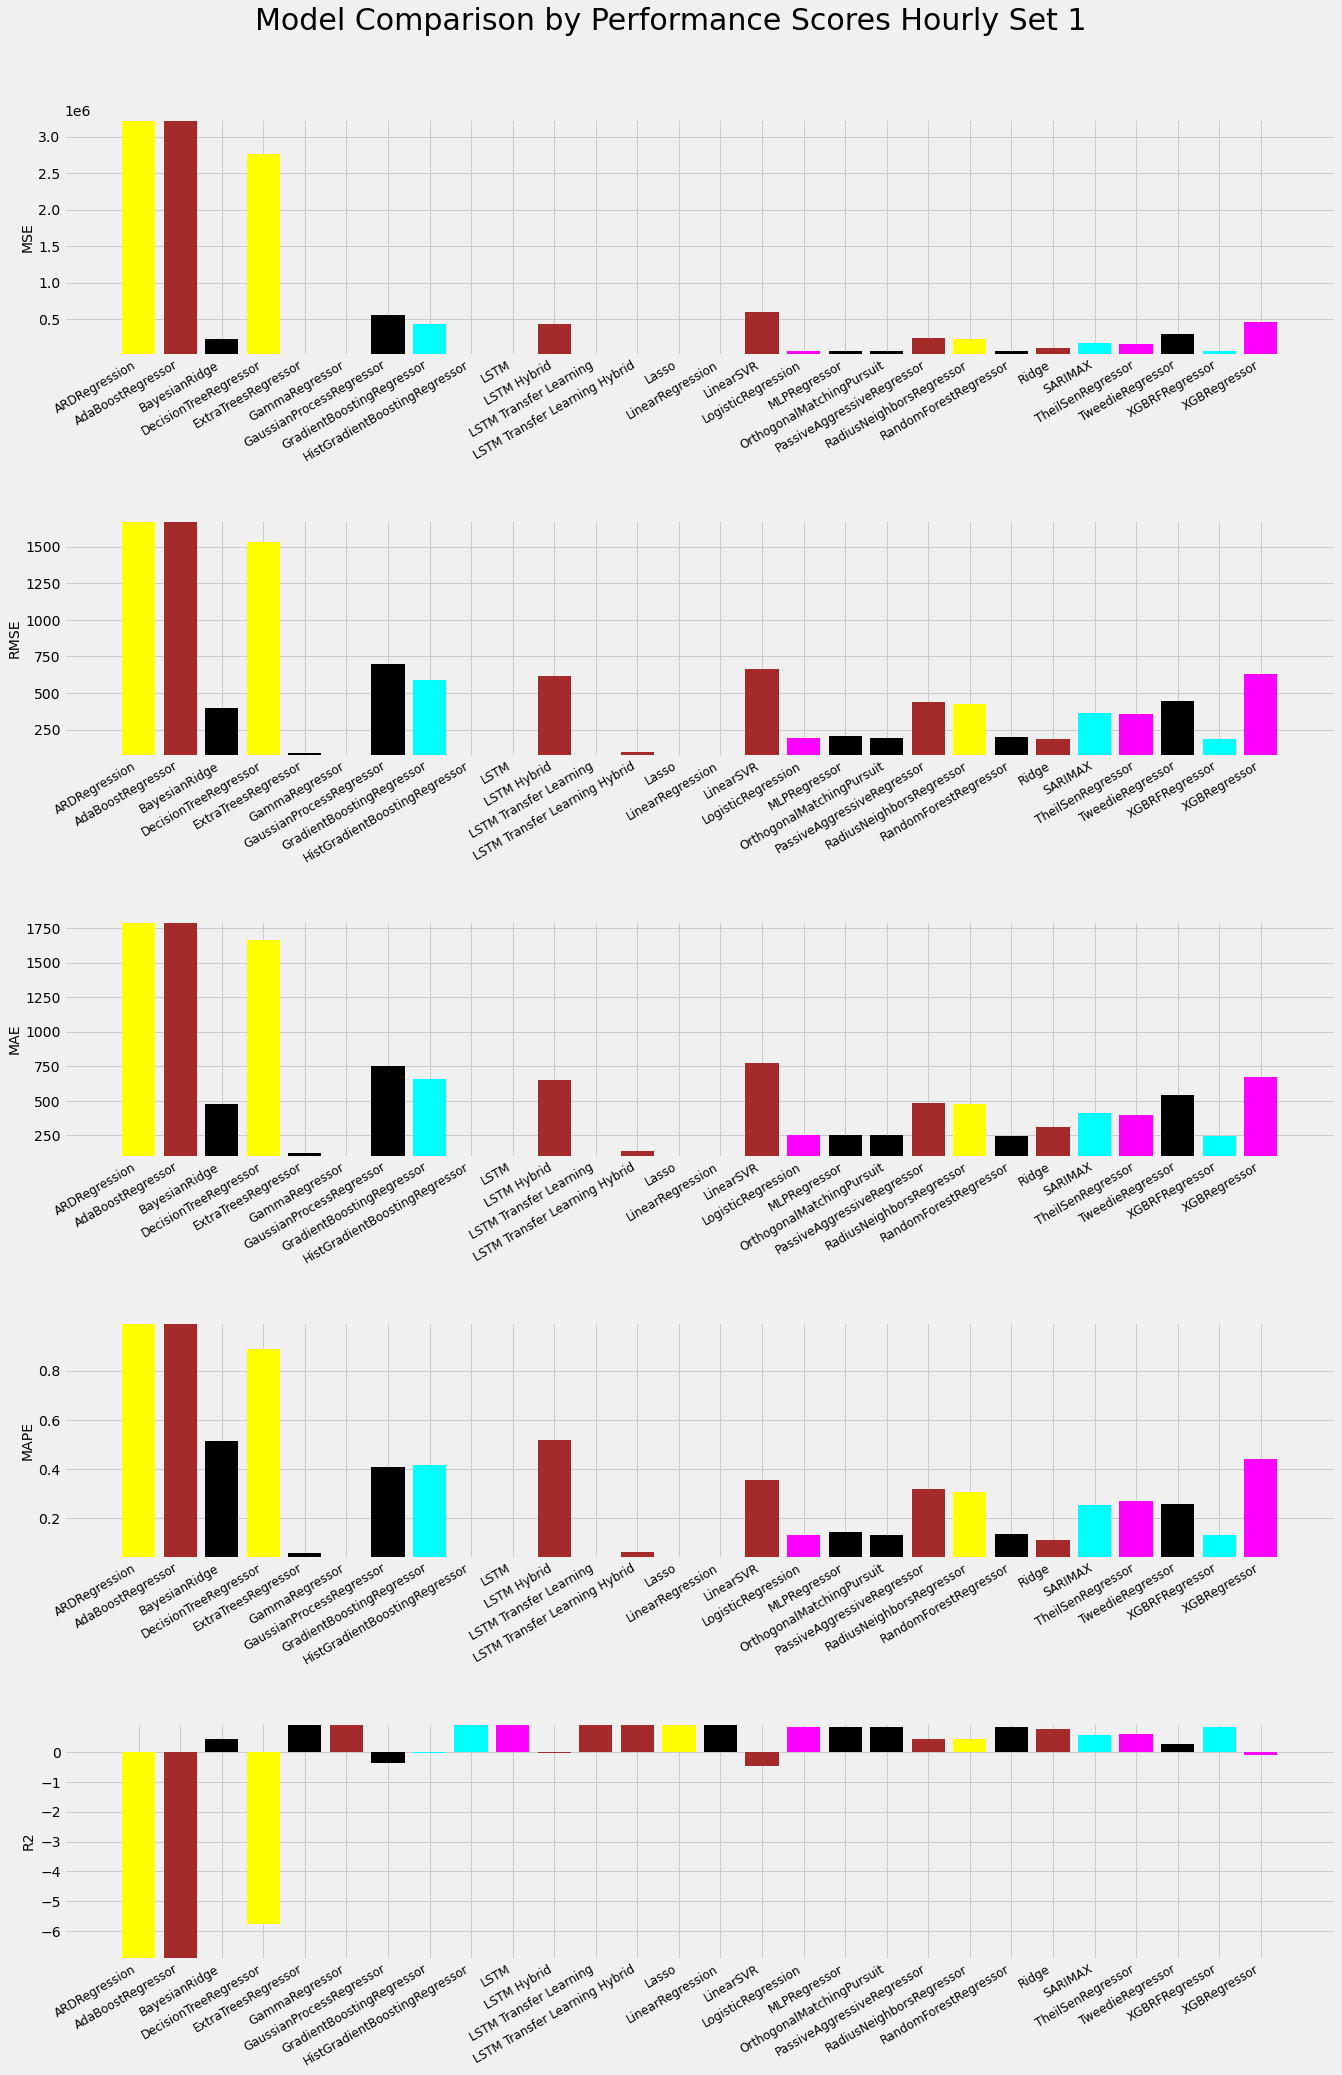

In [20]:
# Read the CSV file
df = pd.read_csv('hourly-Train-test-set_1.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Hourly Set 1', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


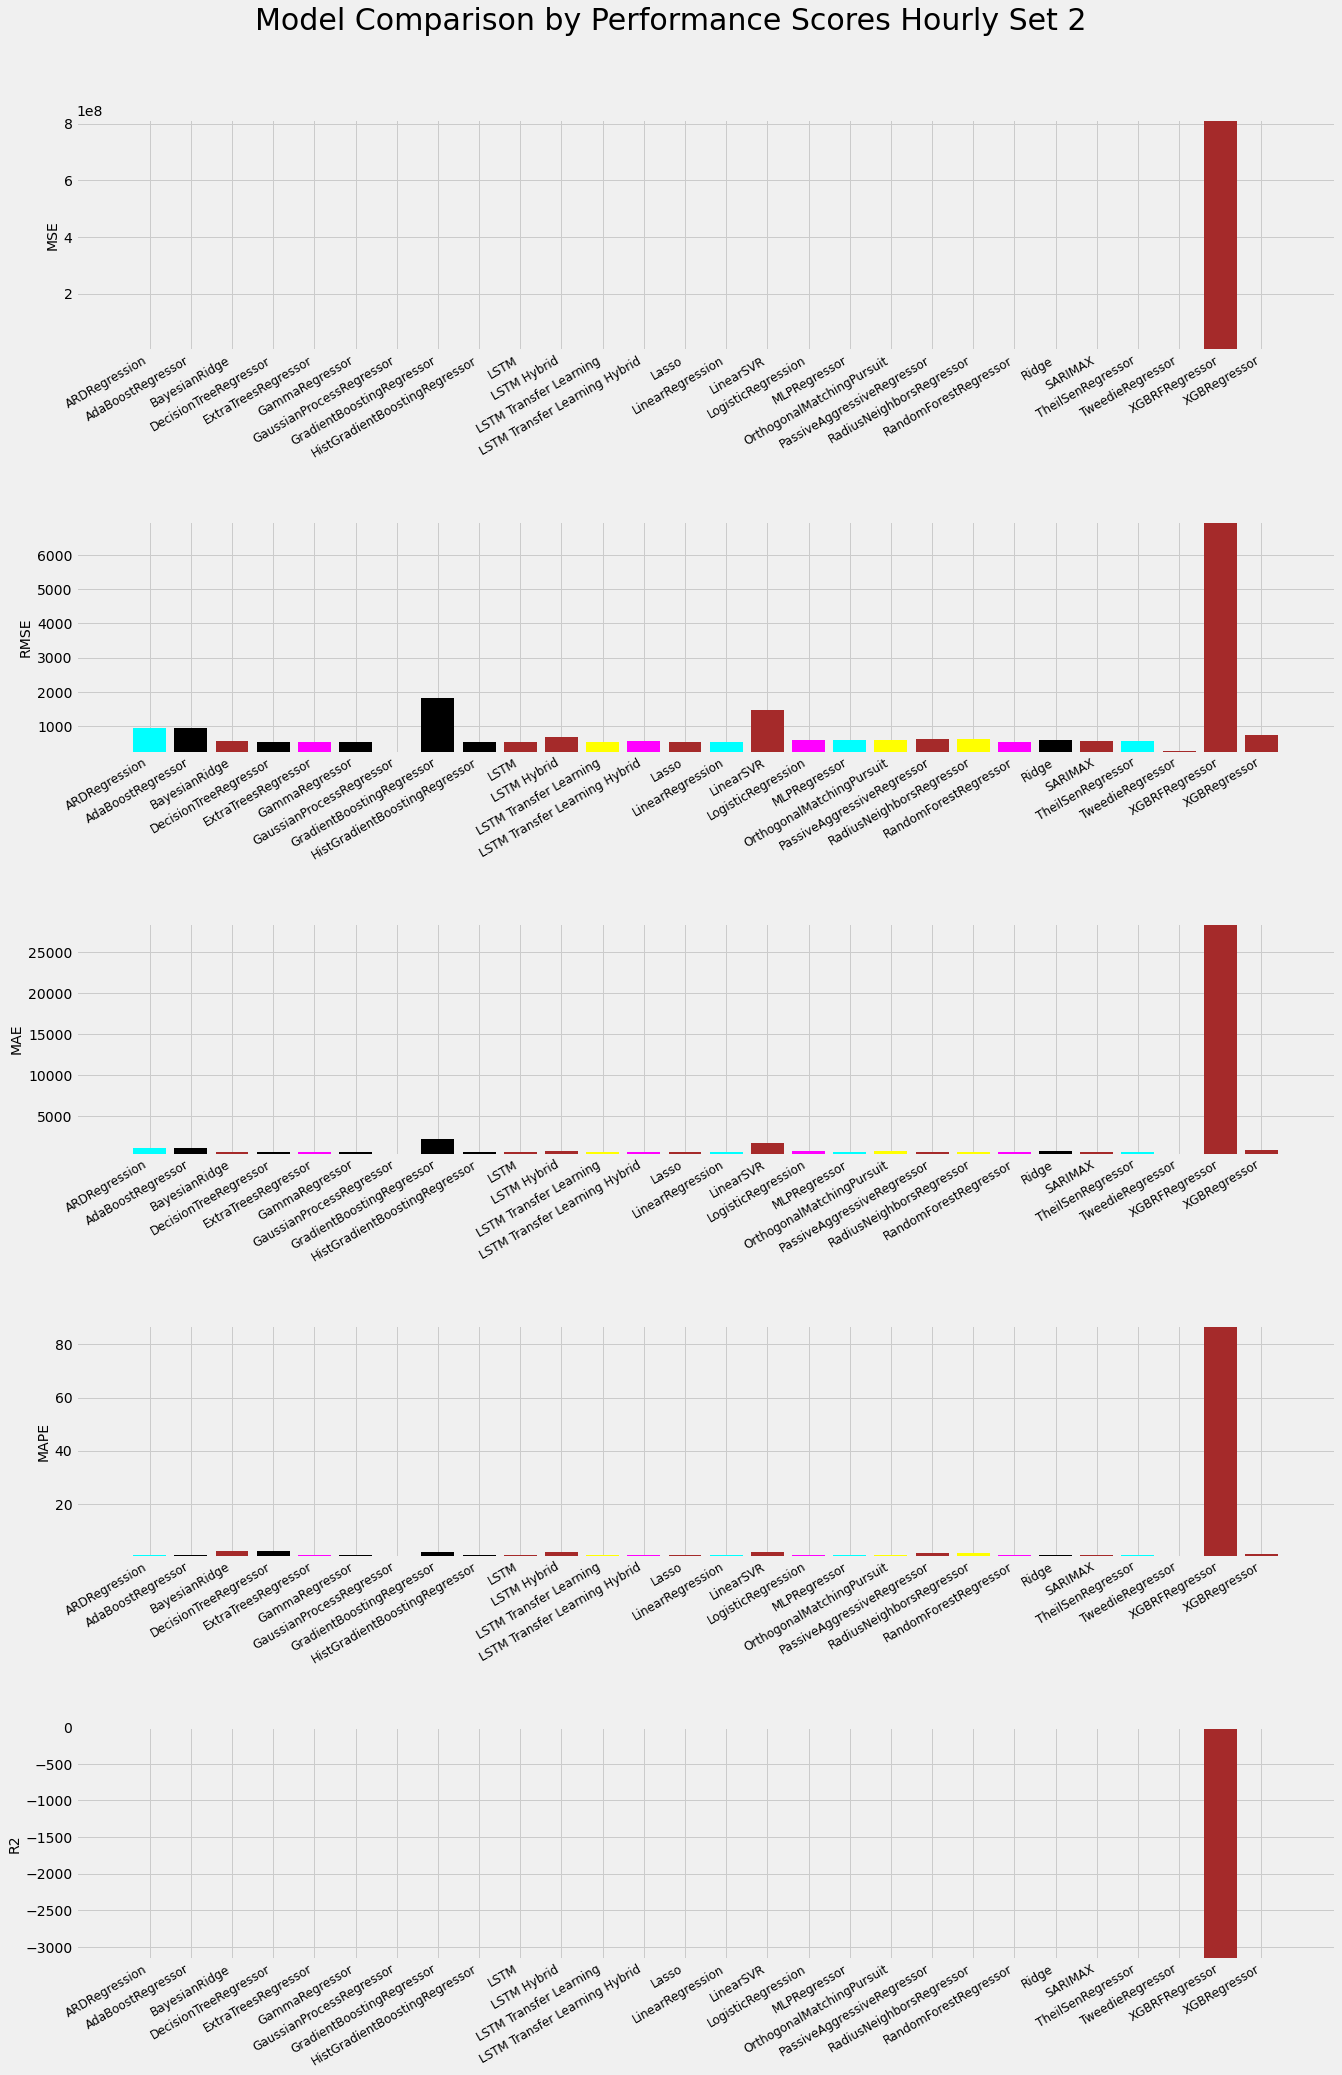

In [21]:
# Read the CSV file
df = pd.read_csv('hourly-Train-test-set_2.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Hourly Set 2', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


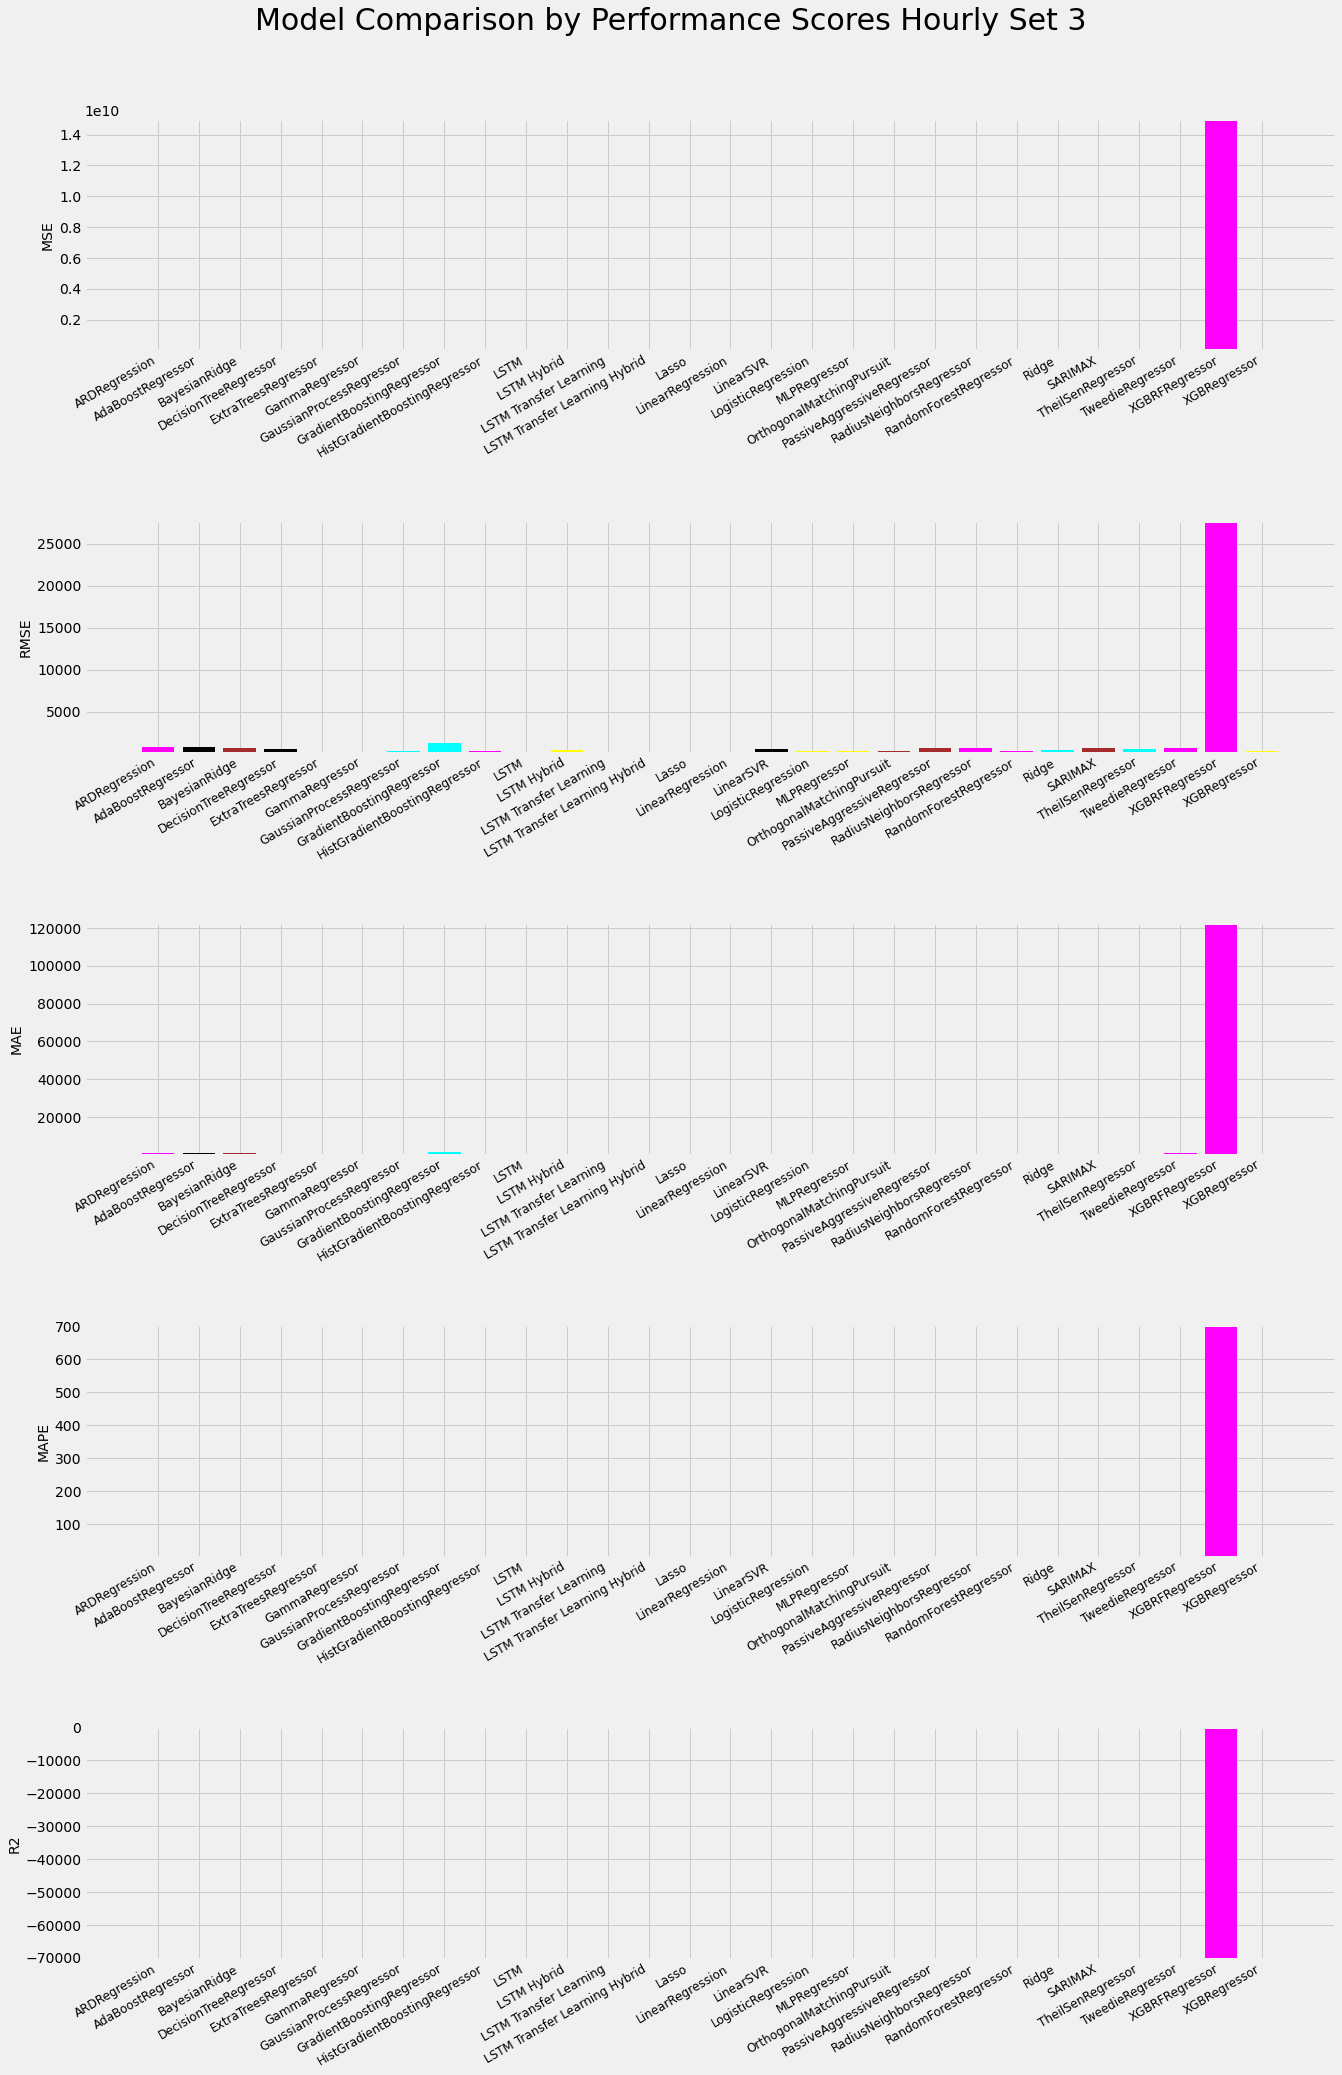

In [22]:
# Read the CSV file
df = pd.read_csv('hourly-Train-test-set_3.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Hourly Set 3', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


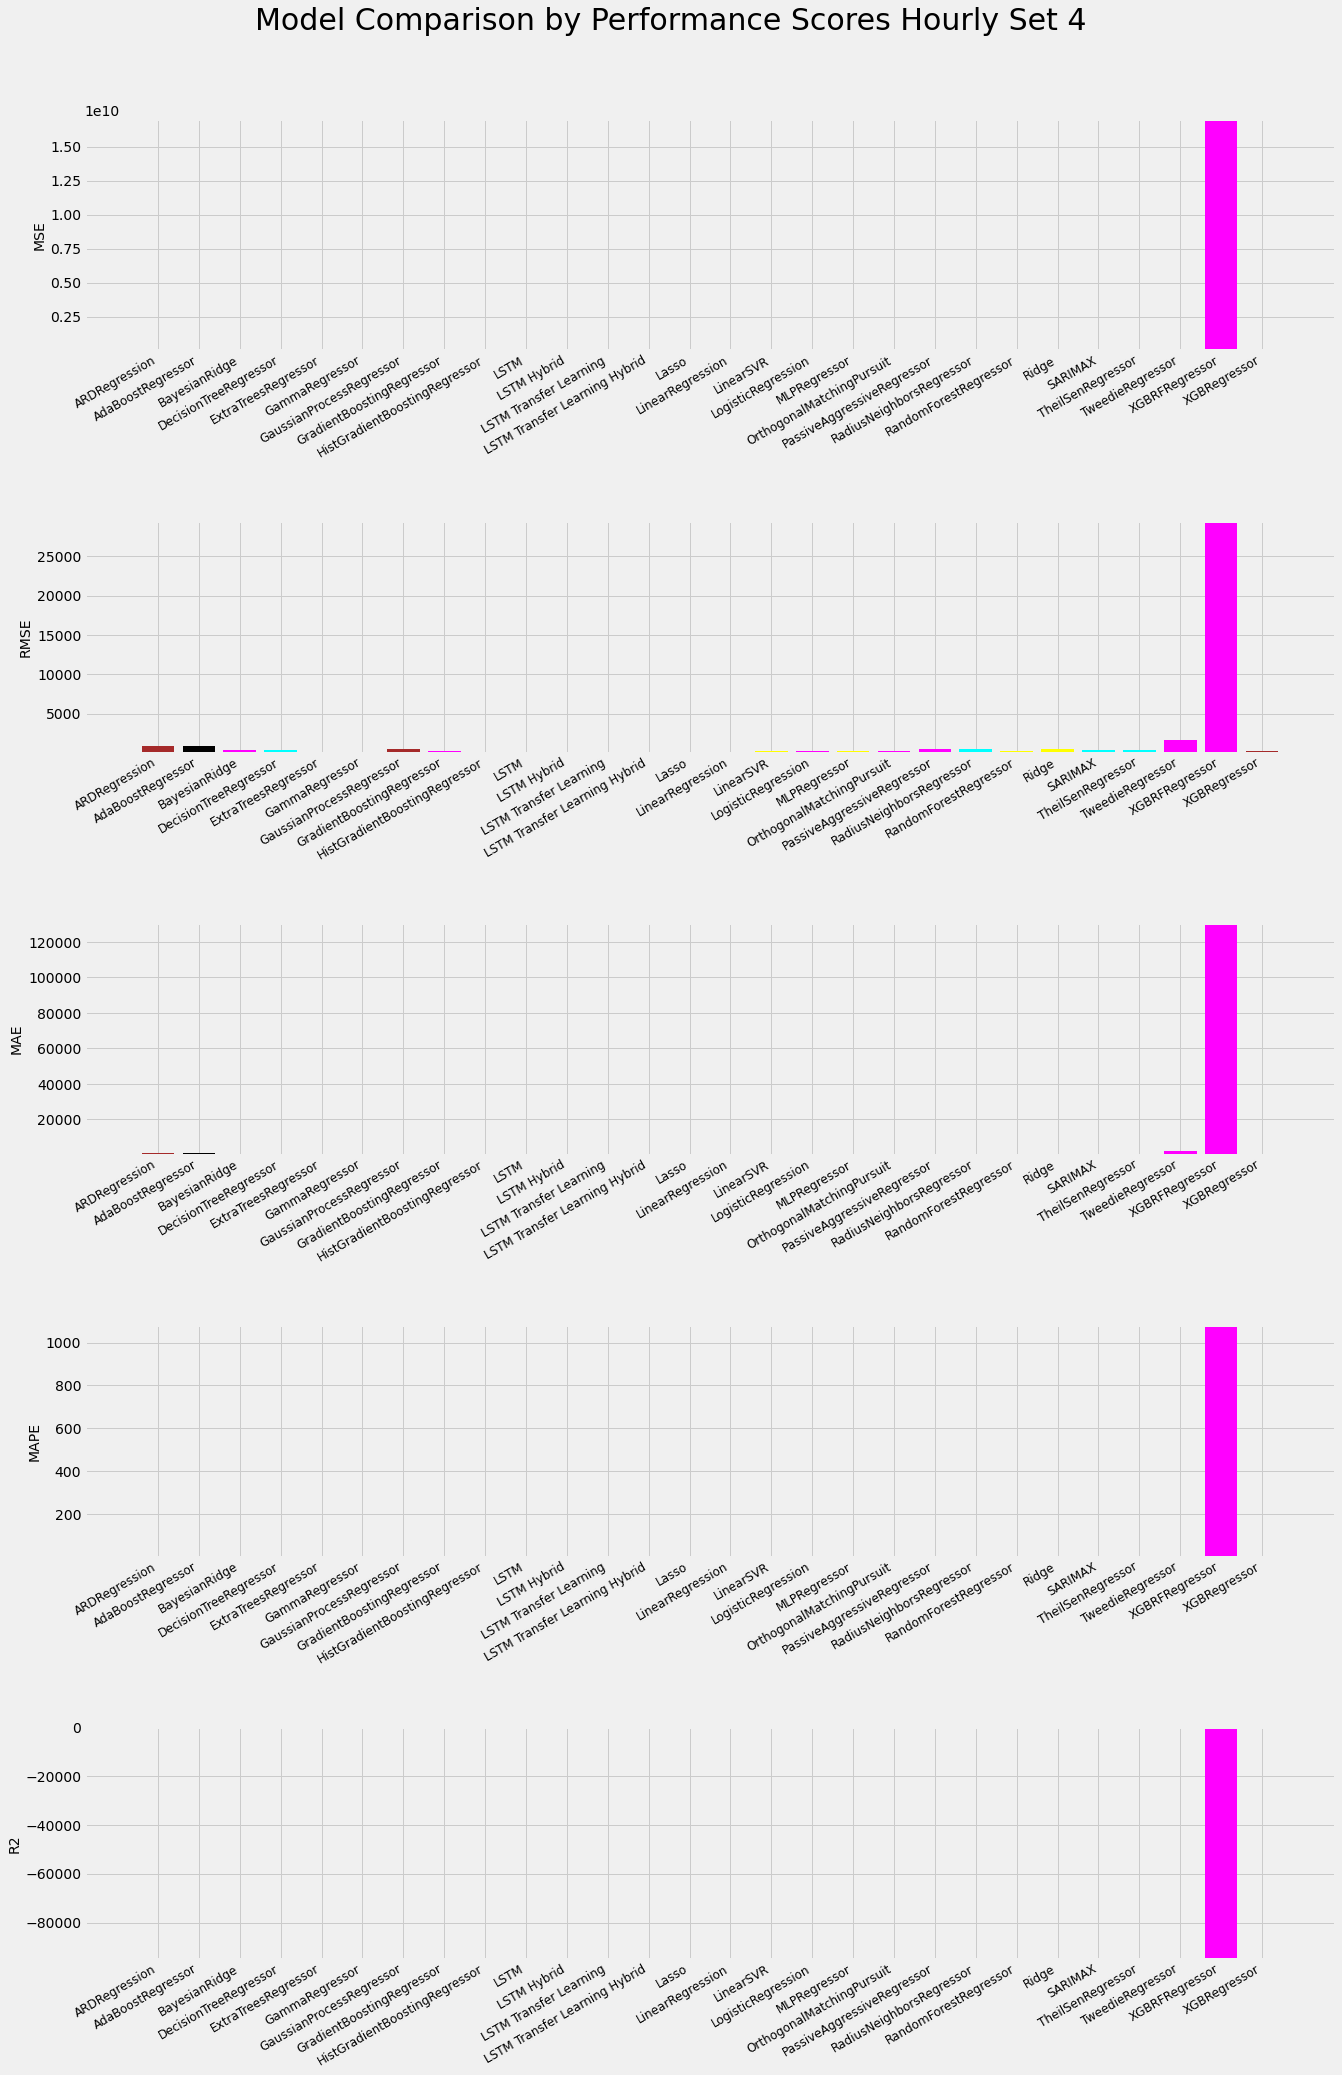

In [23]:
# Read the CSV file
df = pd.read_csv('hourly-Train-test-set_4.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Hourly Set 4', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


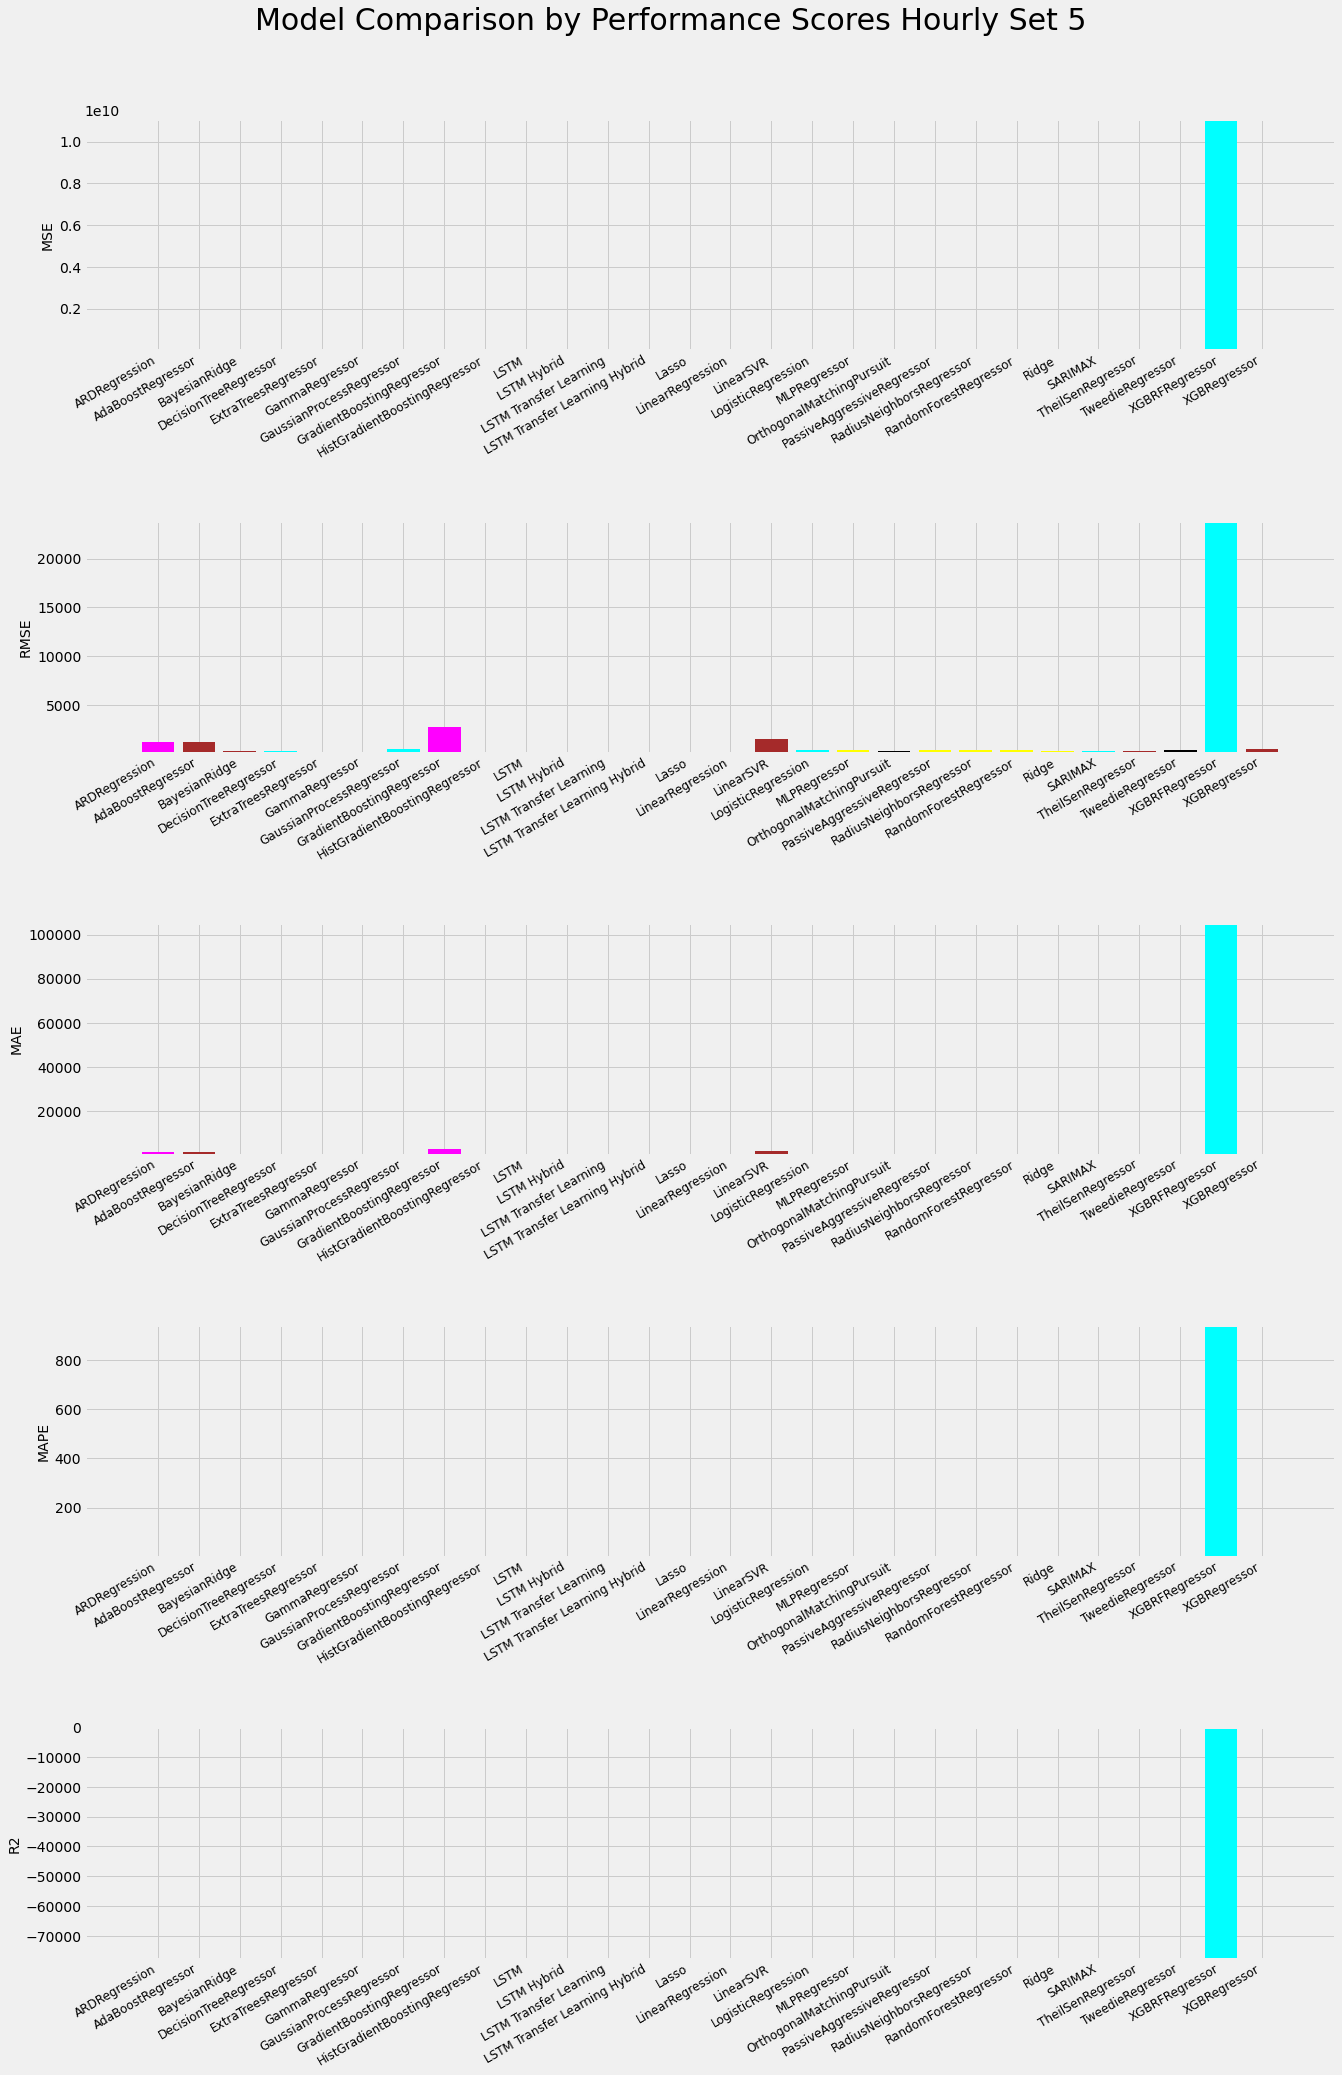

In [24]:
# Read the CSV file
df = pd.read_csv('hourly-Train-test-set_5.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Hourly Set 5', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


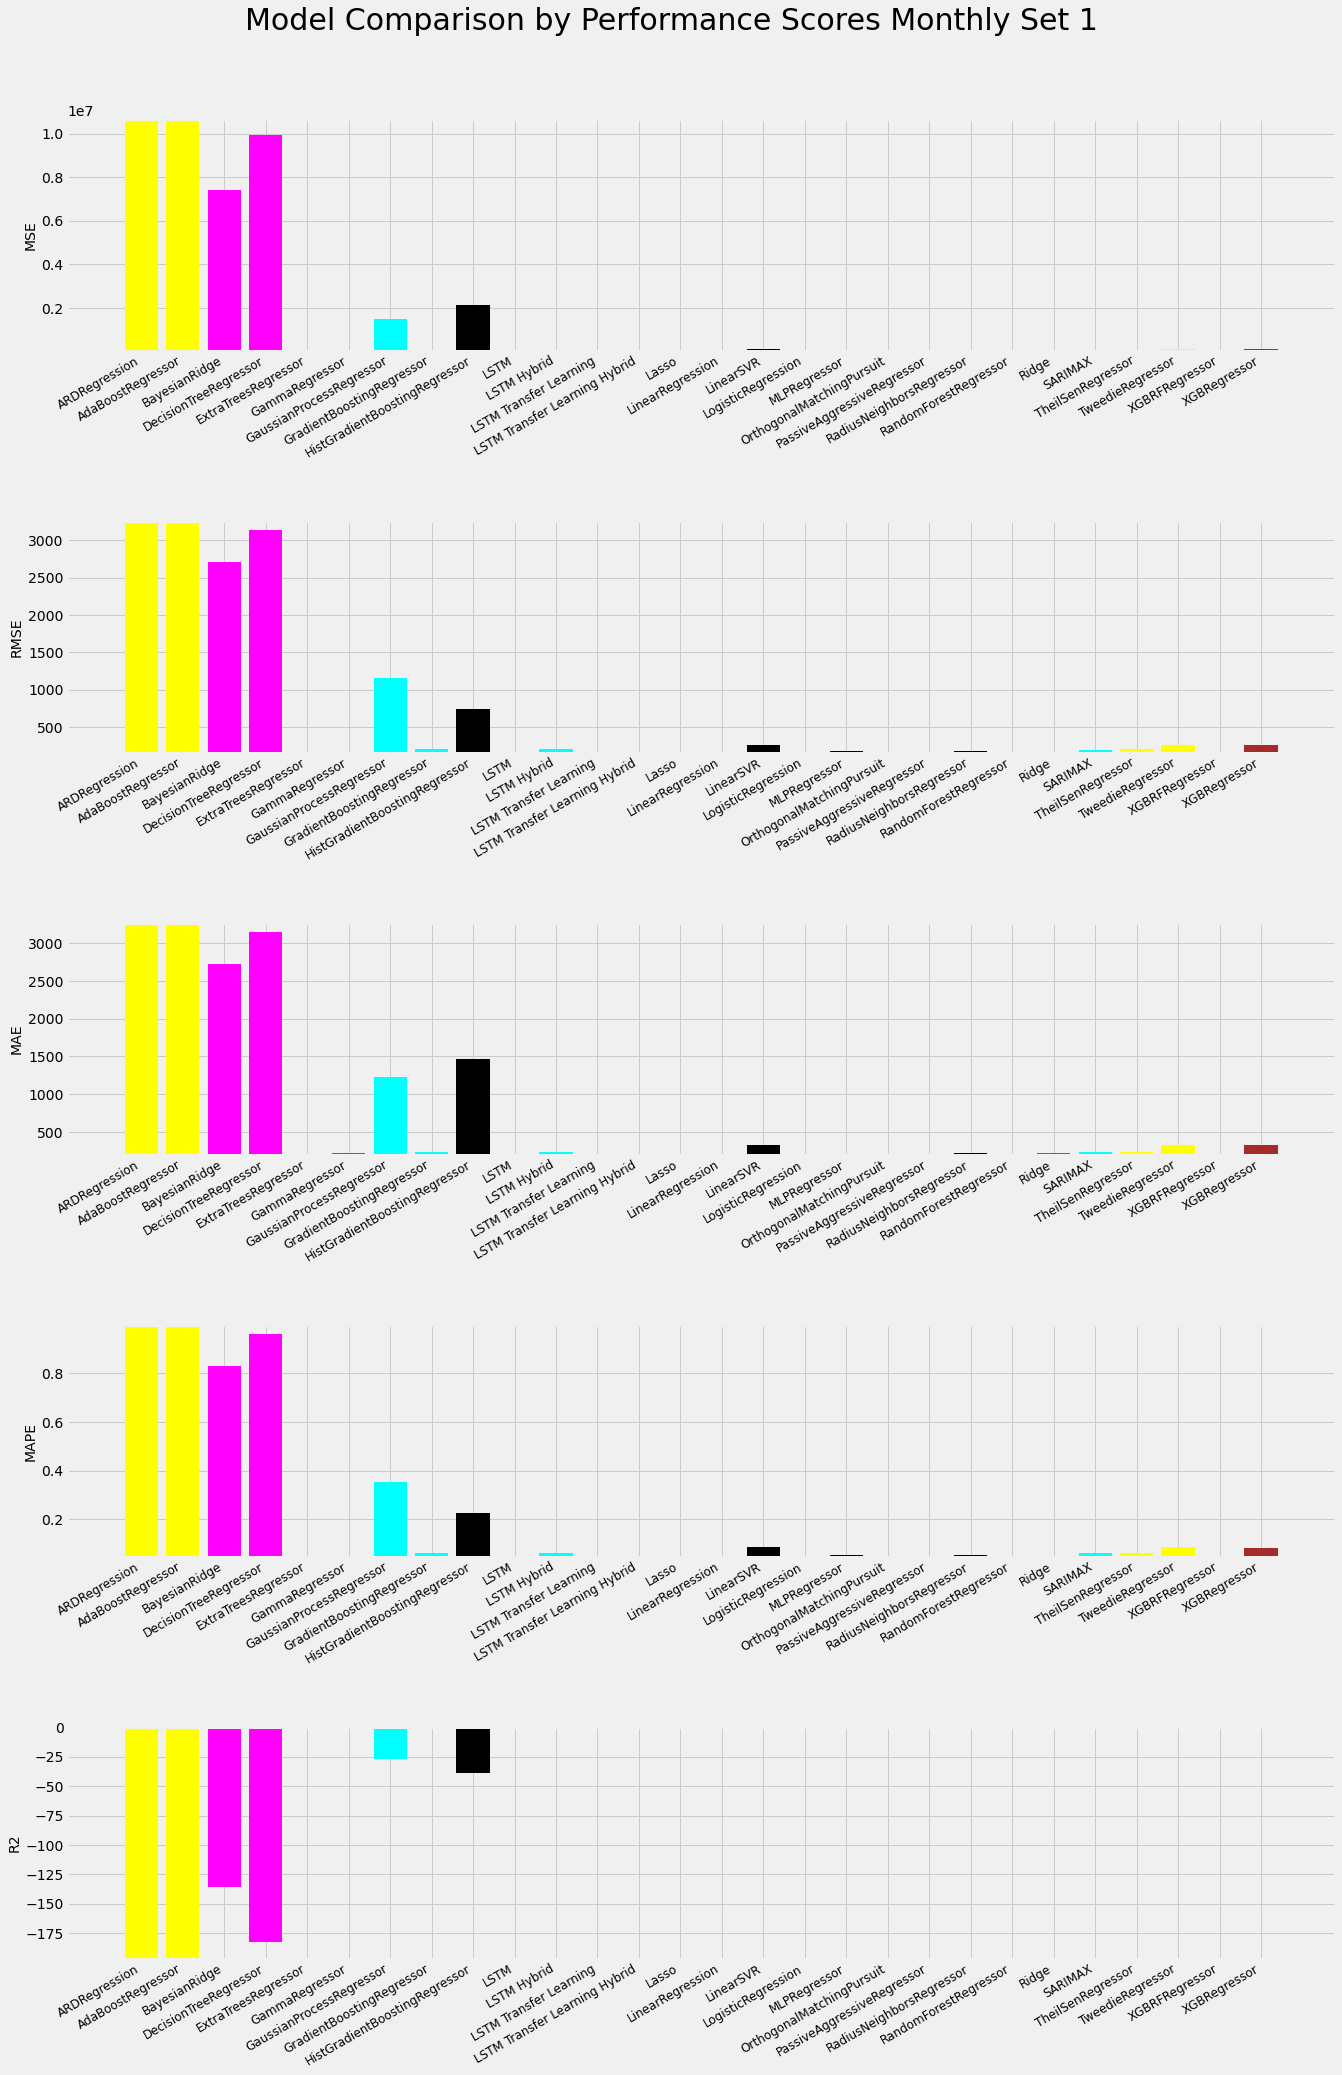

In [25]:
# Read the CSV file
df = pd.read_csv('monthly-Train-test-set_1.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Monthly Set 1', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


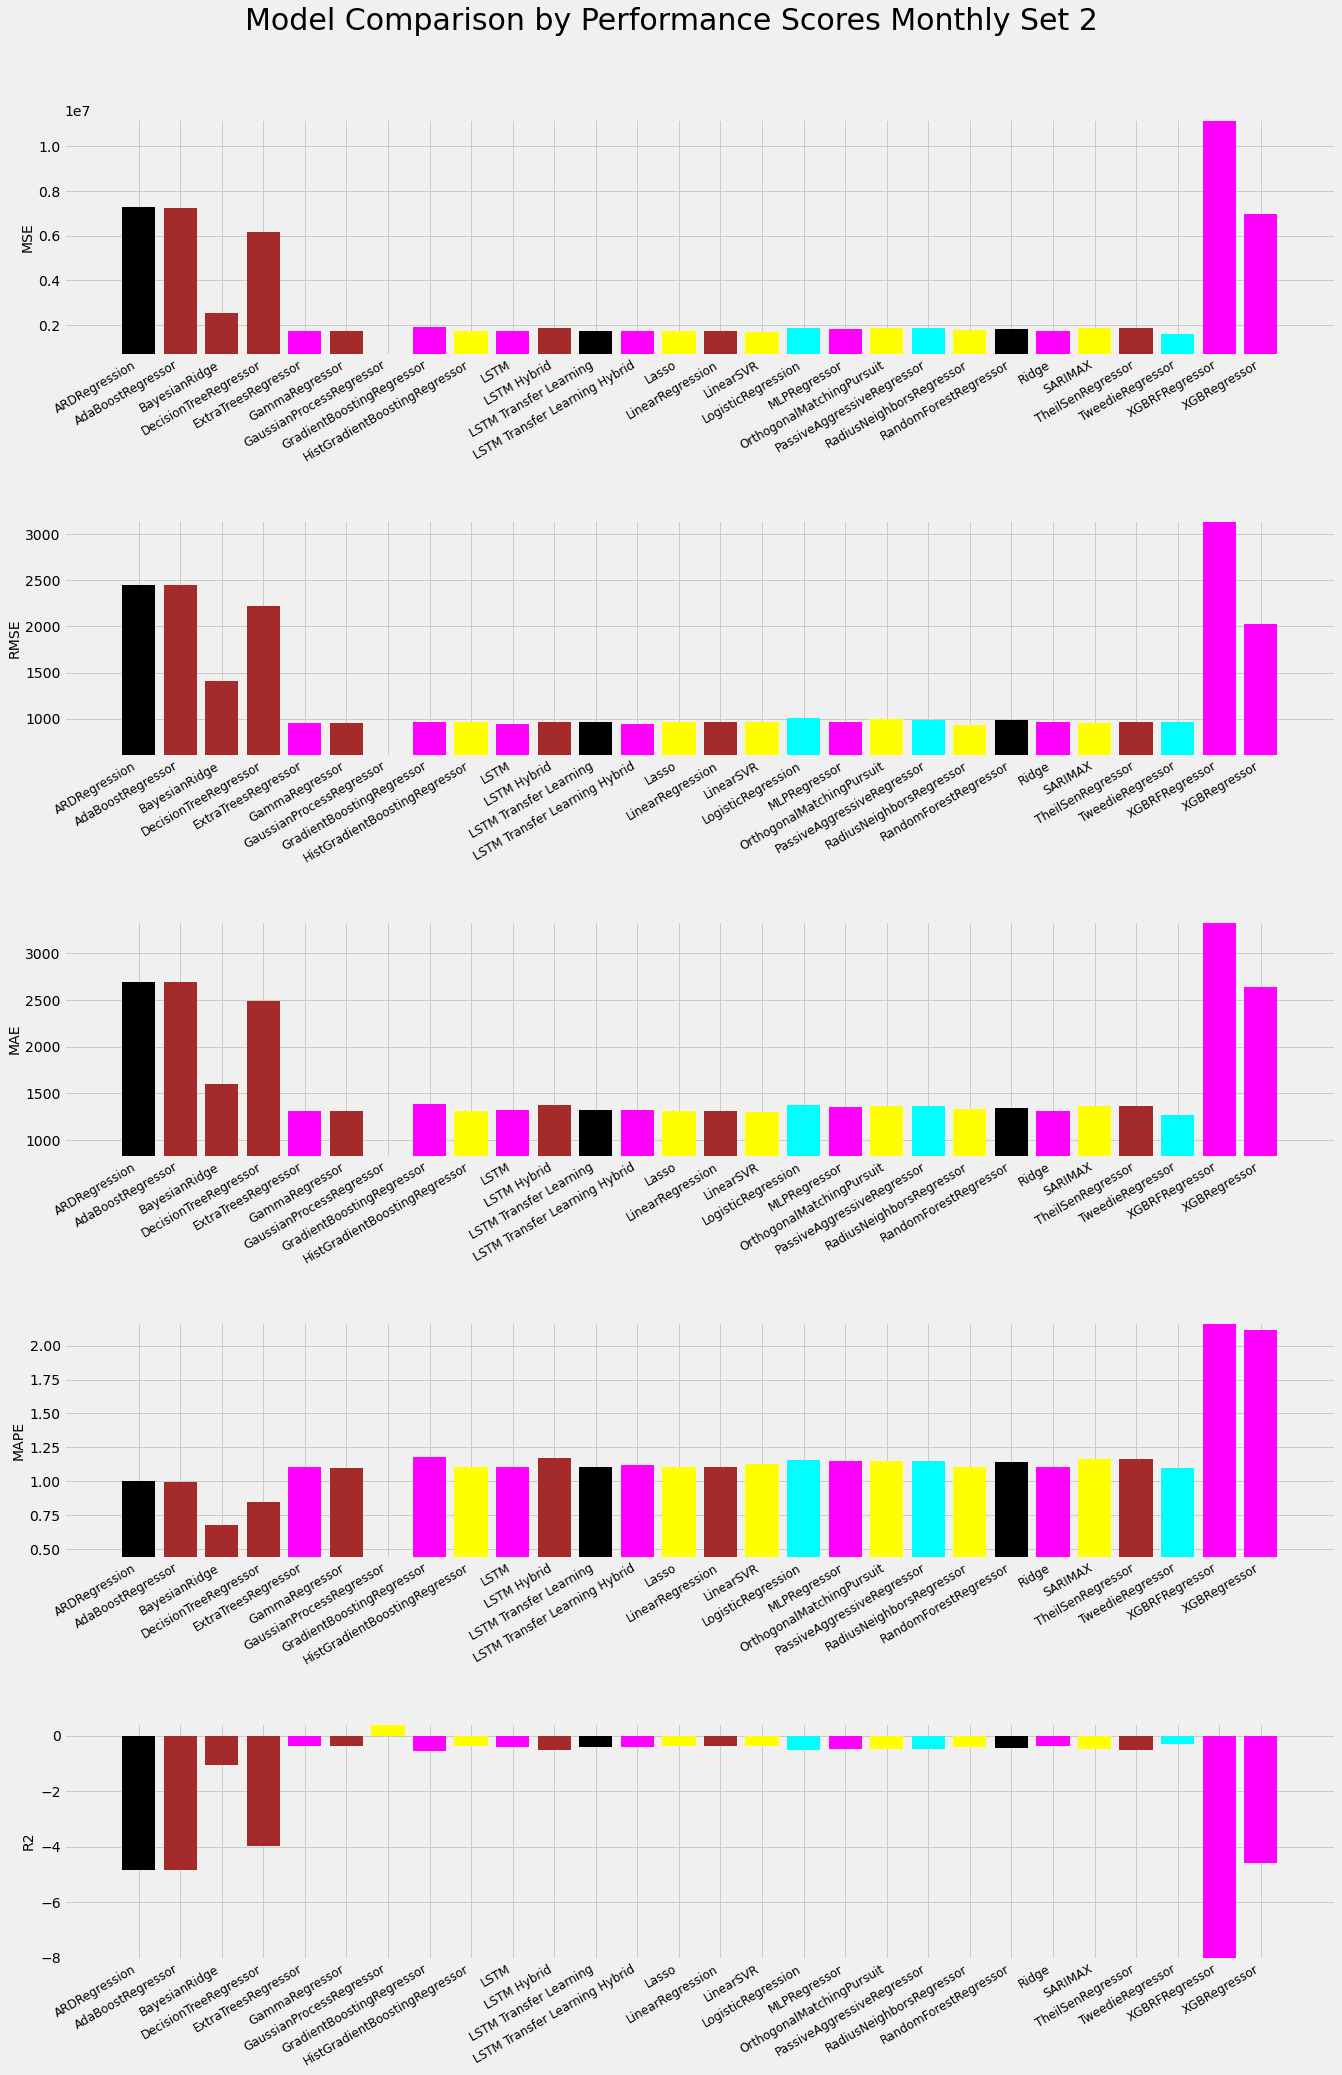

In [26]:
# Read the CSV file
df = pd.read_csv('monthly-Train-test-set_2.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Monthly Set 2', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


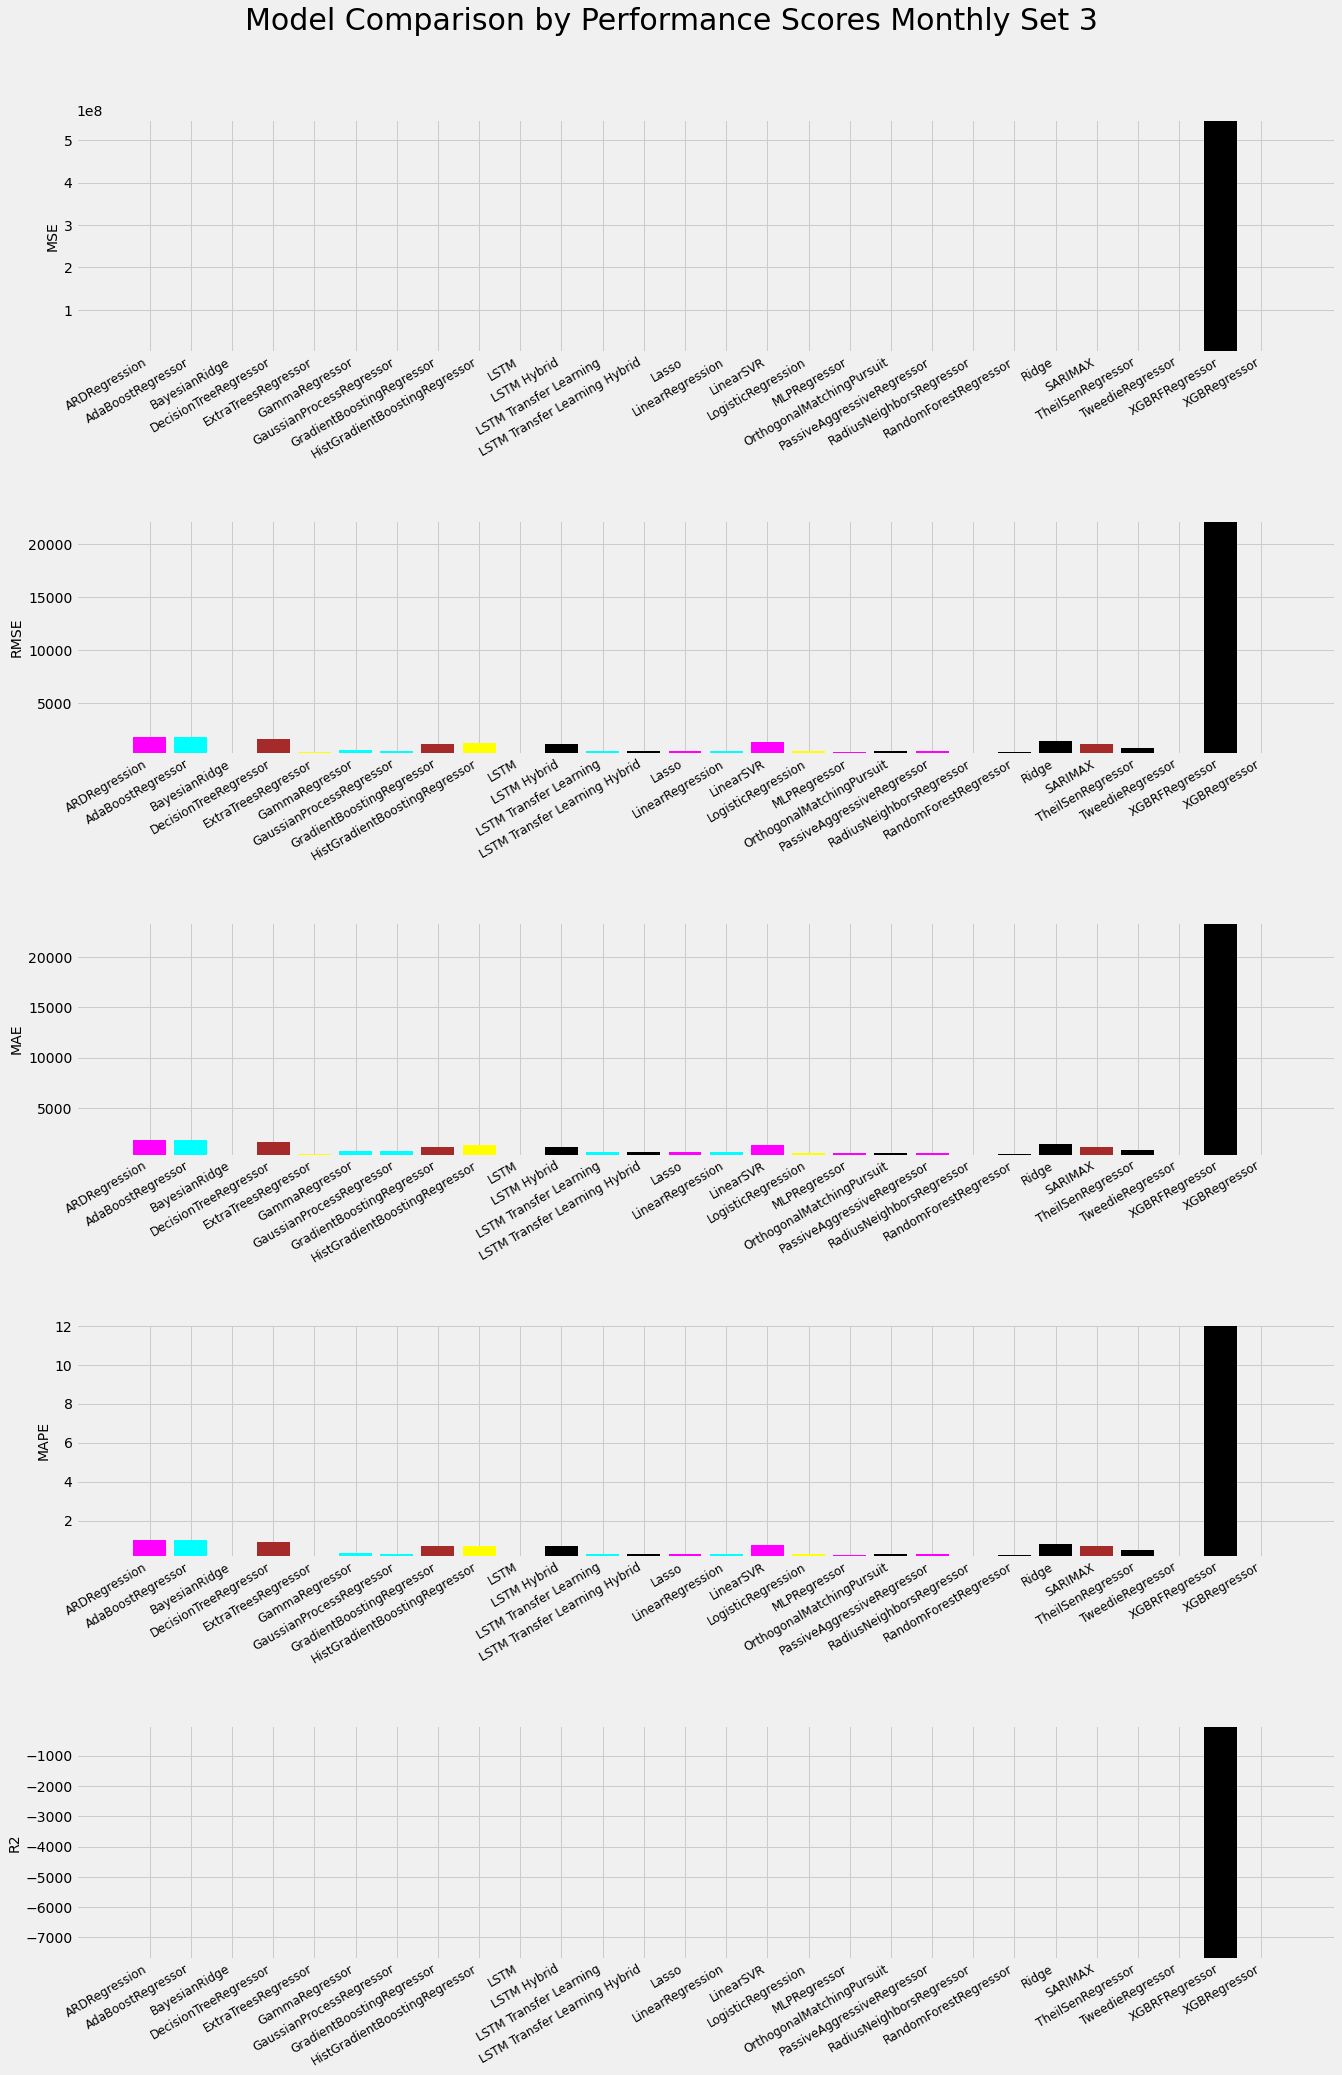

In [27]:
# Read the CSV file
df = pd.read_csv('monthly-Train-test-set_3.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Monthly Set 3', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


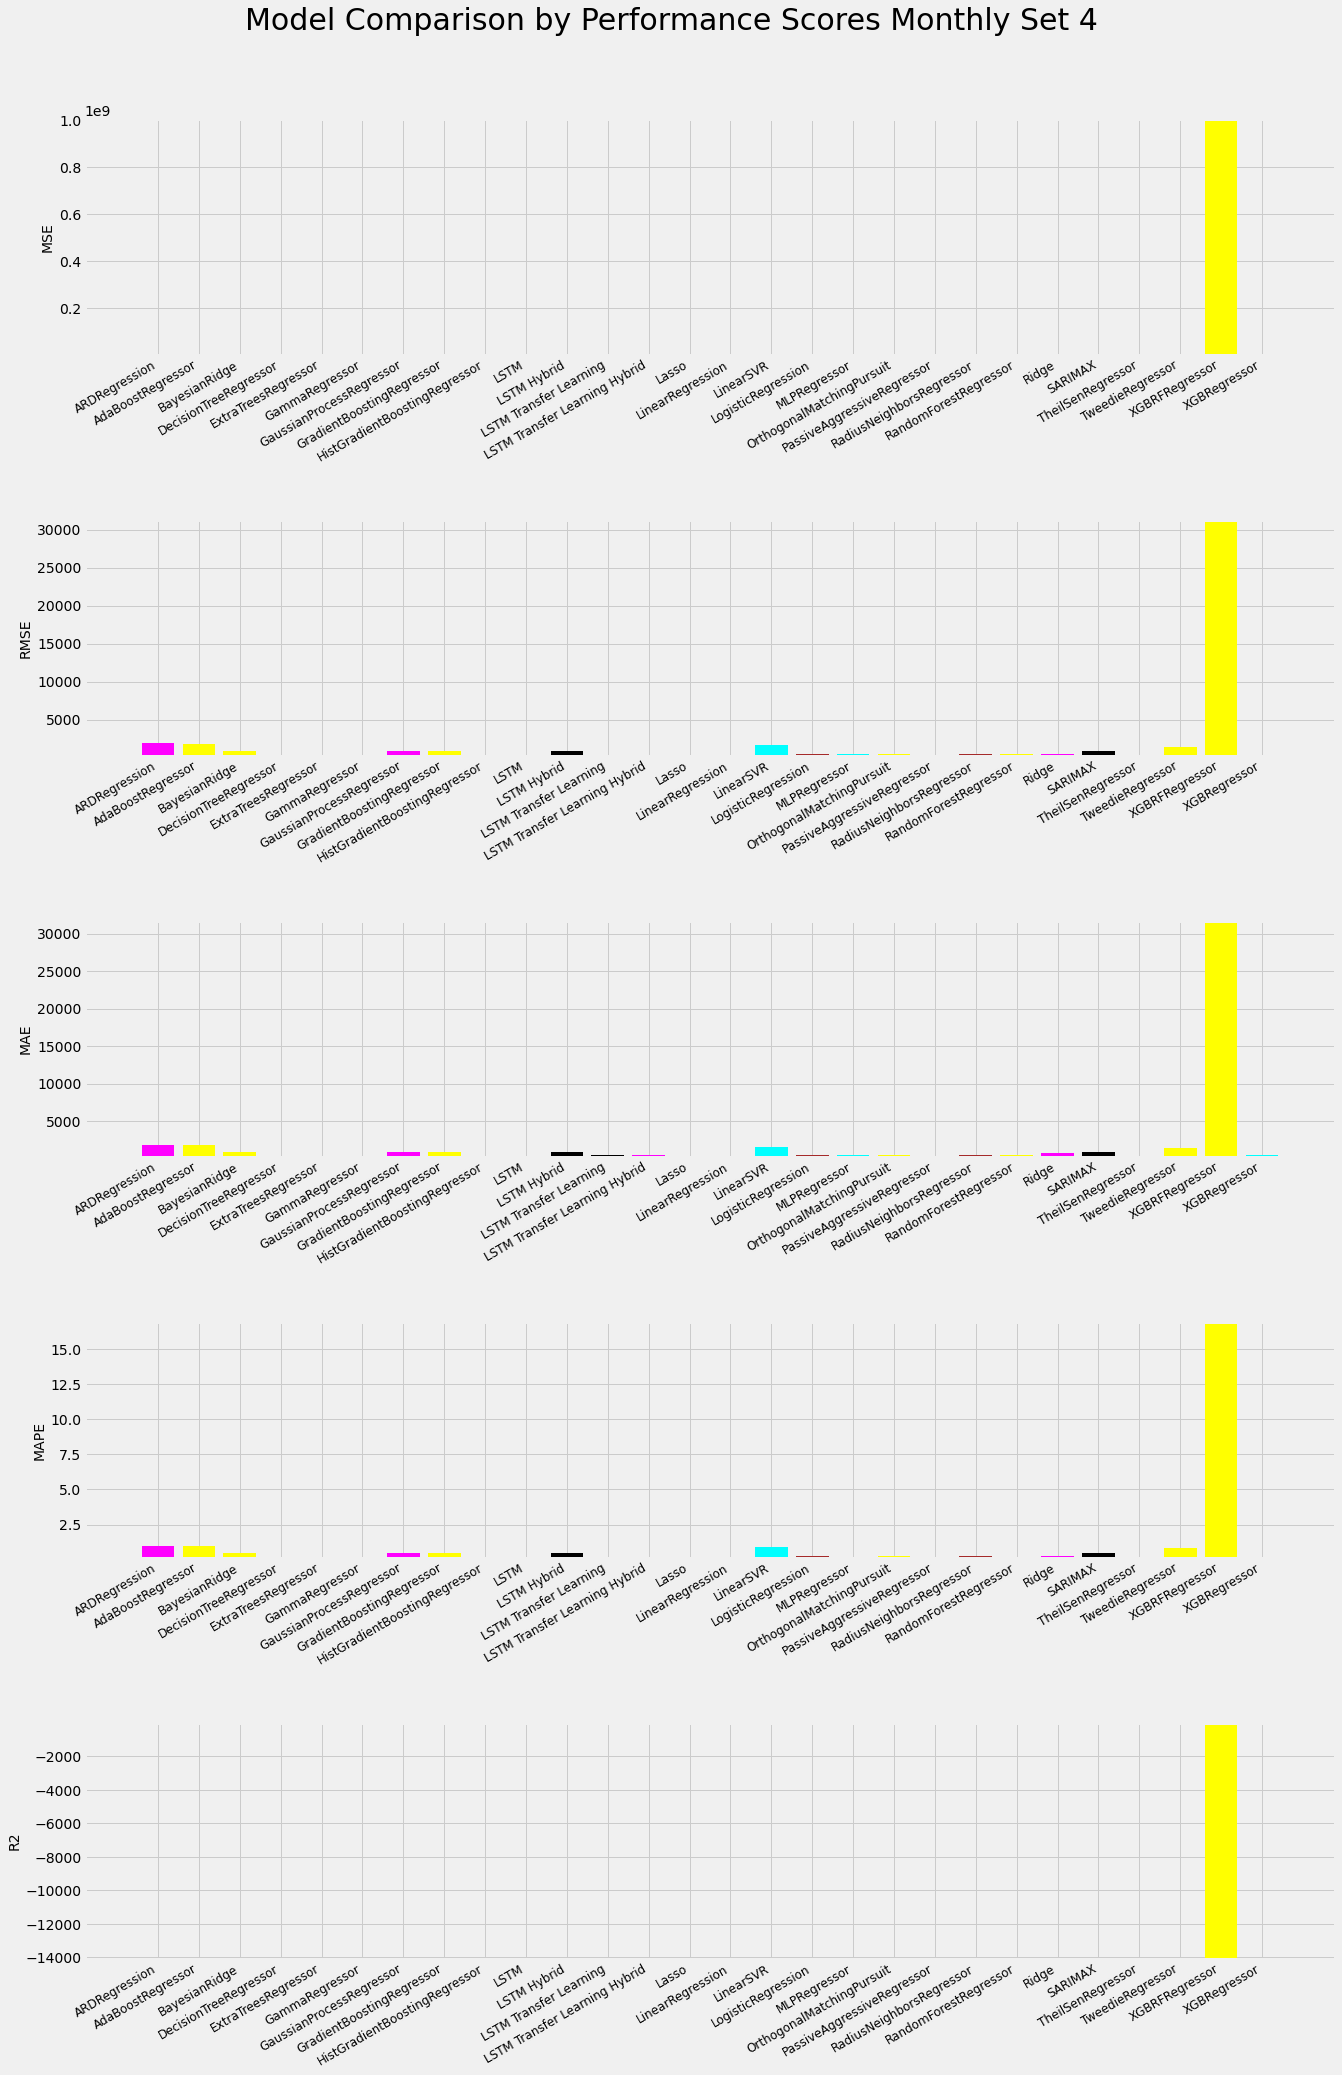

In [28]:
# Read the CSV file
df = pd.read_csv('monthly-Train-test-set_4.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Monthly Set 4', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


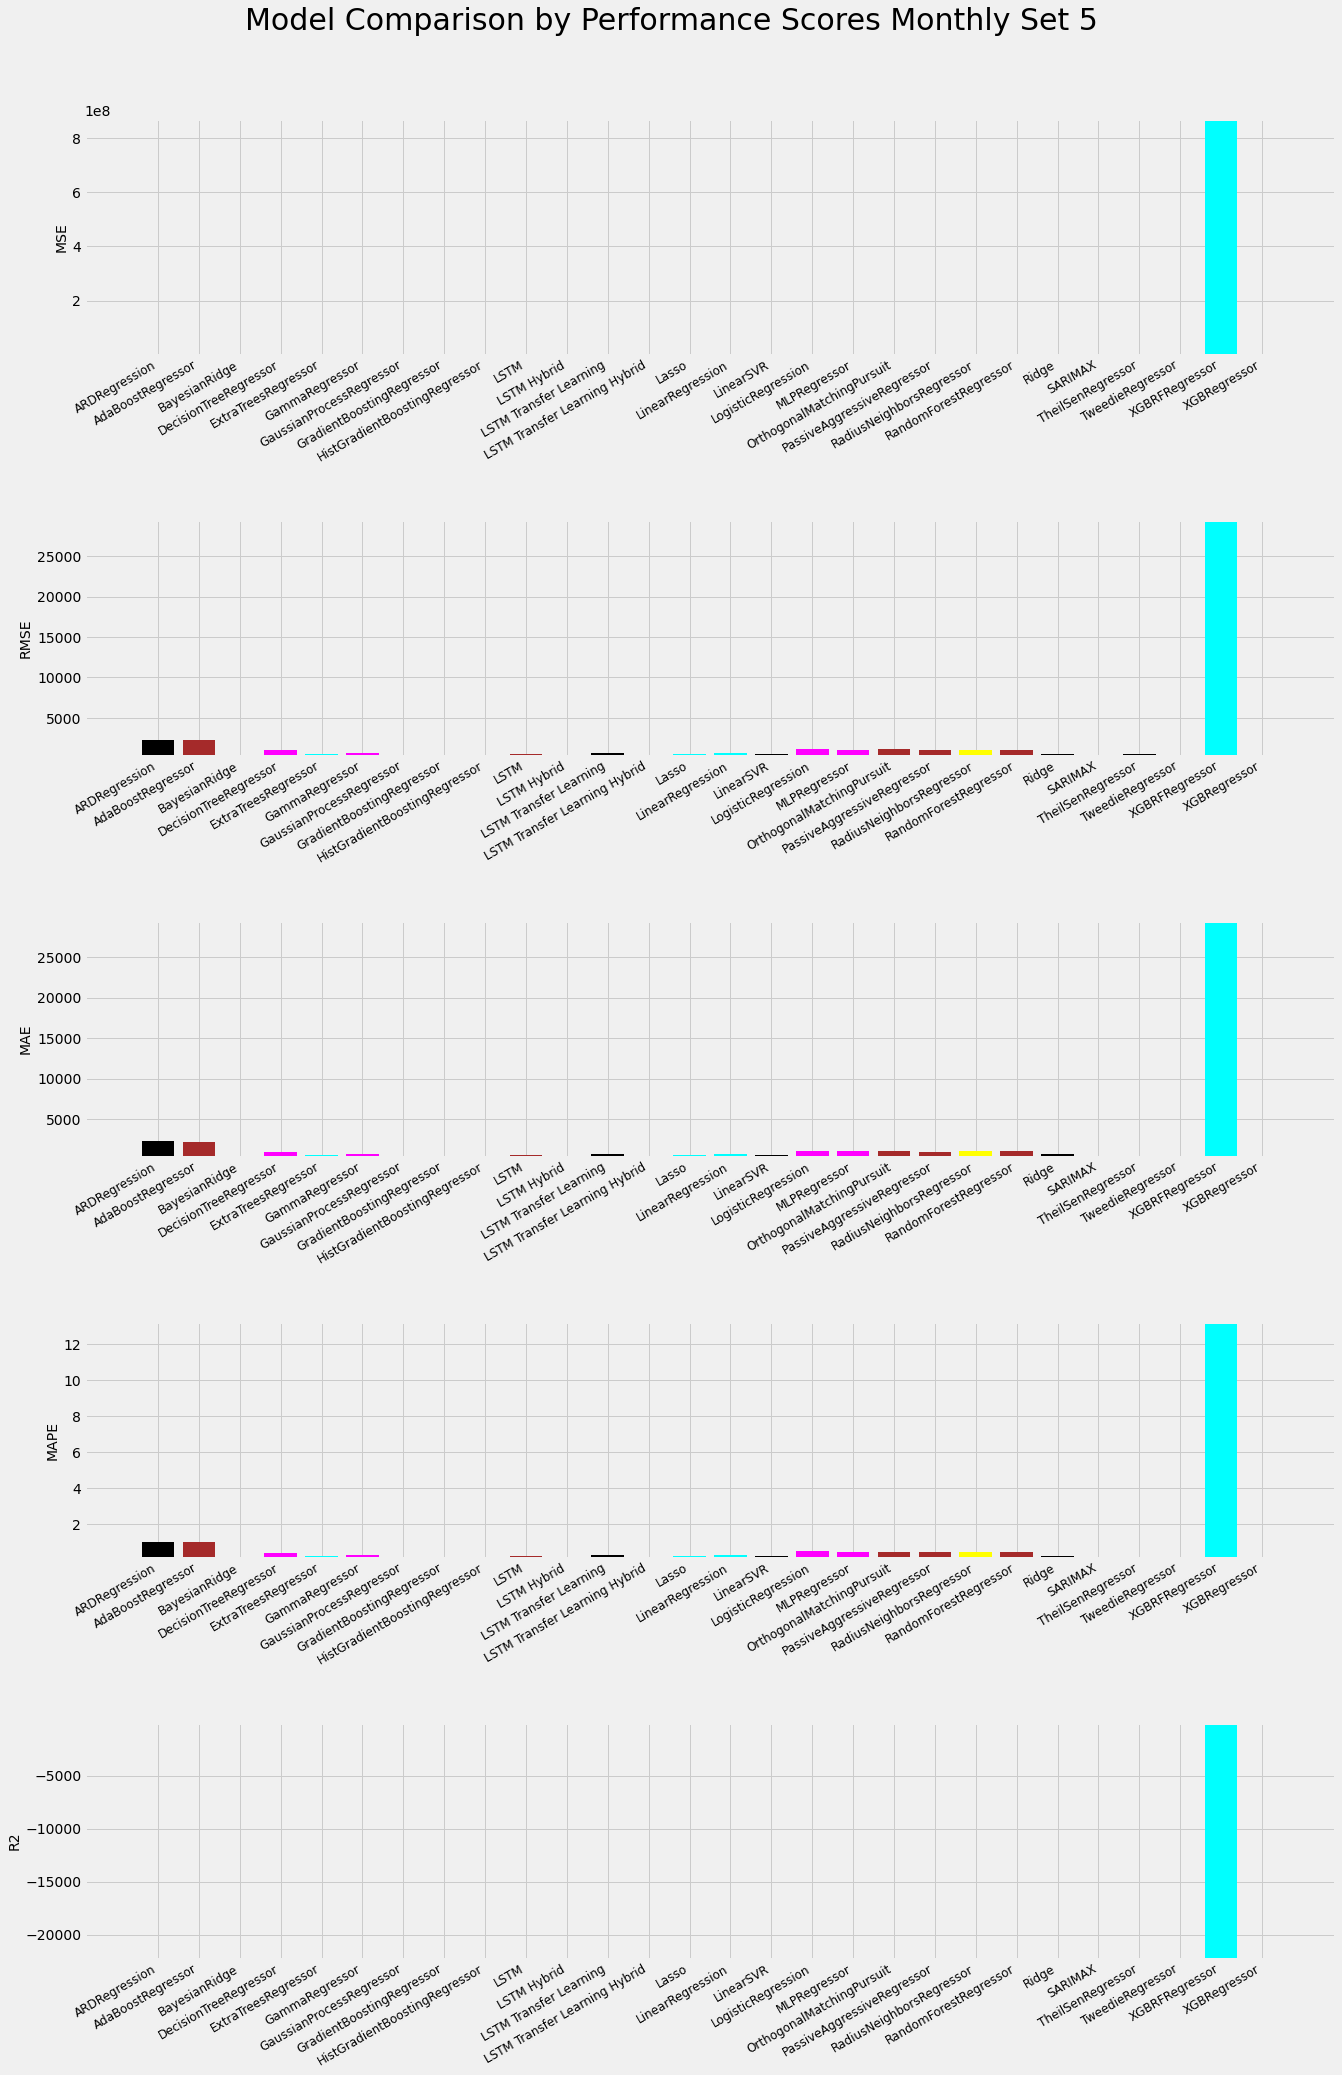

In [29]:
# Read the CSV file
df = pd.read_csv('monthly-Train-test-set_5.csv')

# Get the names of the models
model_names = df.columns[1:]

# Set the x-axis labels
x_labels = sorted(model_names)

# Get the mean scores for each model and performance metric
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[model_names].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[model_names].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[model_names].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[model_names].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[model_names].tolist()

# Fill in missing values with NaN
max_len = max(len(mse_scores), len(rmse_scores), len(mae_scores), len(mape_scores), len(r2_scores))
mse_scores += [np.nan] * (max_len - len(mse_scores))
rmse_scores += [np.nan] * (max_len - len(rmse_scores))
mae_scores += [np.nan] * (max_len - len(mae_scores))
mape_scores += [np.nan] * (max_len - len(mape_scores))
r2_scores += [np.nan] * (max_len - len(r2_scores))

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['black', 'brown', 'yellow', 'cyan', 'magenta']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Model Comparison by Performance Scores Monthly Set 5', fontsize=30)
plt.tight_layout(pad=4)
plt.show()


In [30]:
# Create a list to store the performance dataframes
performance_dataframes = []

# Create a list of file names
files = ['hourly-Train-test-set_1.csv',
         'hourly-Train-test-set_2.csv',
         'hourly-Train-test-set_3.csv',
         'hourly-Train-test-set_4.csv',
         'hourly-Train-test-set_5.csv']

# Load each CSV file into a DataFrame and store them in a list
dfs = [pd.read_csv(file) for file in files]

# Concatenate the DataFrames in the list vertically (i.e. stack them on top of each other)
combined_df = pd.concat(dfs, axis=0)

# Write the combined DataFrame to a new CSV file
combined_df.to_csv('combined_hourly_train_test_sets.csv', index=False)

                                      MSE        RMSE         MAE      MAPE  \
TheilSenRegressor            61410.904936  187.636299  247.812237  0.132290   
PassiveAggressiveRegressor  292929.696043  444.379085  541.229800  0.256666   
MLPRegressor                429691.646074  587.378732  655.508693  0.414769   

                                  R2  
TheilSenRegressor           0.849974  
PassiveAggressiveRegressor  0.284378  
MLPRegressor               -0.049729  


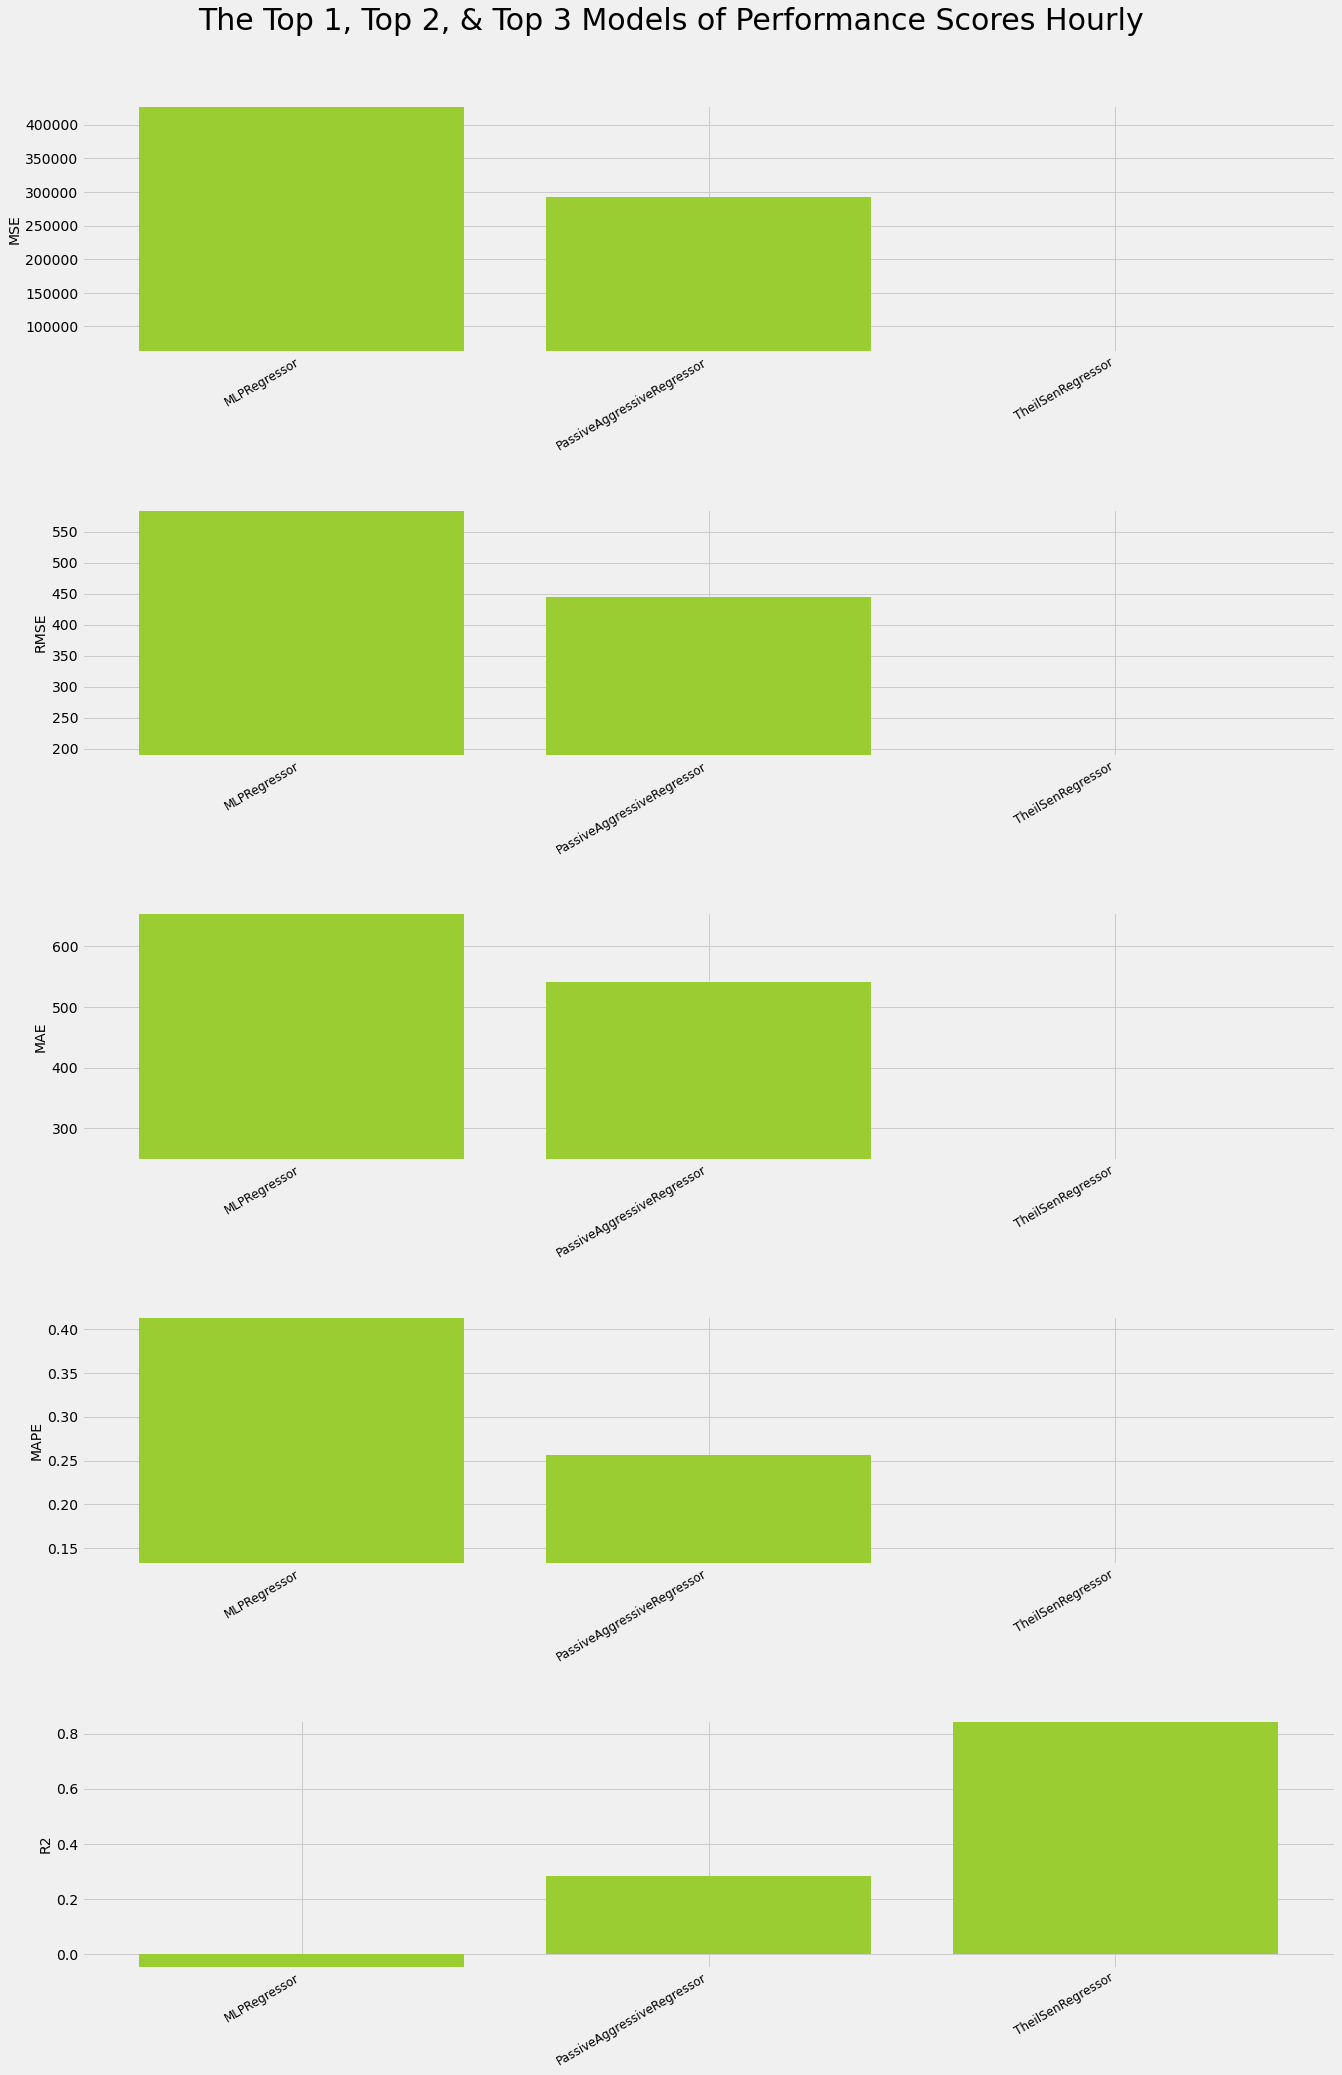

In [32]:
# Read the combined CSV file
df = pd.read_csv('combined_hourly_train_test_sets.csv')

# Get the names of the models
model_names = df.columns[1:]

# Get the maximum scores for each model across all performance metrics
max_scores = df.select_dtypes(include=[float]).loc[:, model_names].max()

# Sort the models by their maximum score in descending order and select the top 3 models
top_models = max_scores.sort_values(ascending=False).head(3).index.tolist()

# Set the x-axis labels to the top 3 models
x_labels = sorted(top_models)

# Get the mean scores for each model and performance metric for the top 3 models
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[x_labels].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[x_labels].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[x_labels].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[x_labels].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[x_labels].tolist()

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['green', 'darkolivegreen', 'darkslategray', 'mediumseagreen', 'yellowgreen']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('The Top 1, Top 2, & Top 3 Models of Performance Scores Hourly', fontsize=30)
plt.tight_layout(pad=4)

# Create a dataframe to store the performance scores
performance = pd.DataFrame(y_scores, columns=x_labels, index=y_labels)

# Get the top 3 models for each metric
performance_sorted = performance.T.sort_values(['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'])
print(performance_sorted)


In [33]:
# Create a list to store the performance dataframes
performance_dataframes = []

# Create a list of file names
files = ['monthly-Train-test-set_1.csv',
         'monthly-Train-test-set_2.csv',
         'monthly-Train-test-set_3.csv',
         'monthly-Train-test-set_4.csv',
         'monthly-Train-test-set_5.csv']

# Load each CSV file into a DataFrame and store them in a list
dfs = [pd.read_csv(file) for file in files]

# Concatenate the DataFrames in the list vertically (i.e. stack them on top of each other)
combined_df = pd.concat(dfs, axis=0)

# Write the combined DataFrame to a new CSV file
combined_df.to_csv('combined_monthly_train_test_sets.csv', index=False)

                                 MSE         RMSE          MAE      MAPE  \
TheilSenRegressor       3.827893e+04   153.378345   195.650023  0.046521   
LSTM Transfer Learning  1.065538e+07  3255.977768  3264.257279  0.998390   
LSTM                    1.067760e+07  3259.388628  3267.659497  0.999442   

                                R2  
TheilSenRegressor         0.290926  
LSTM Transfer Learning -196.378937  
LSTM                   -196.790593  


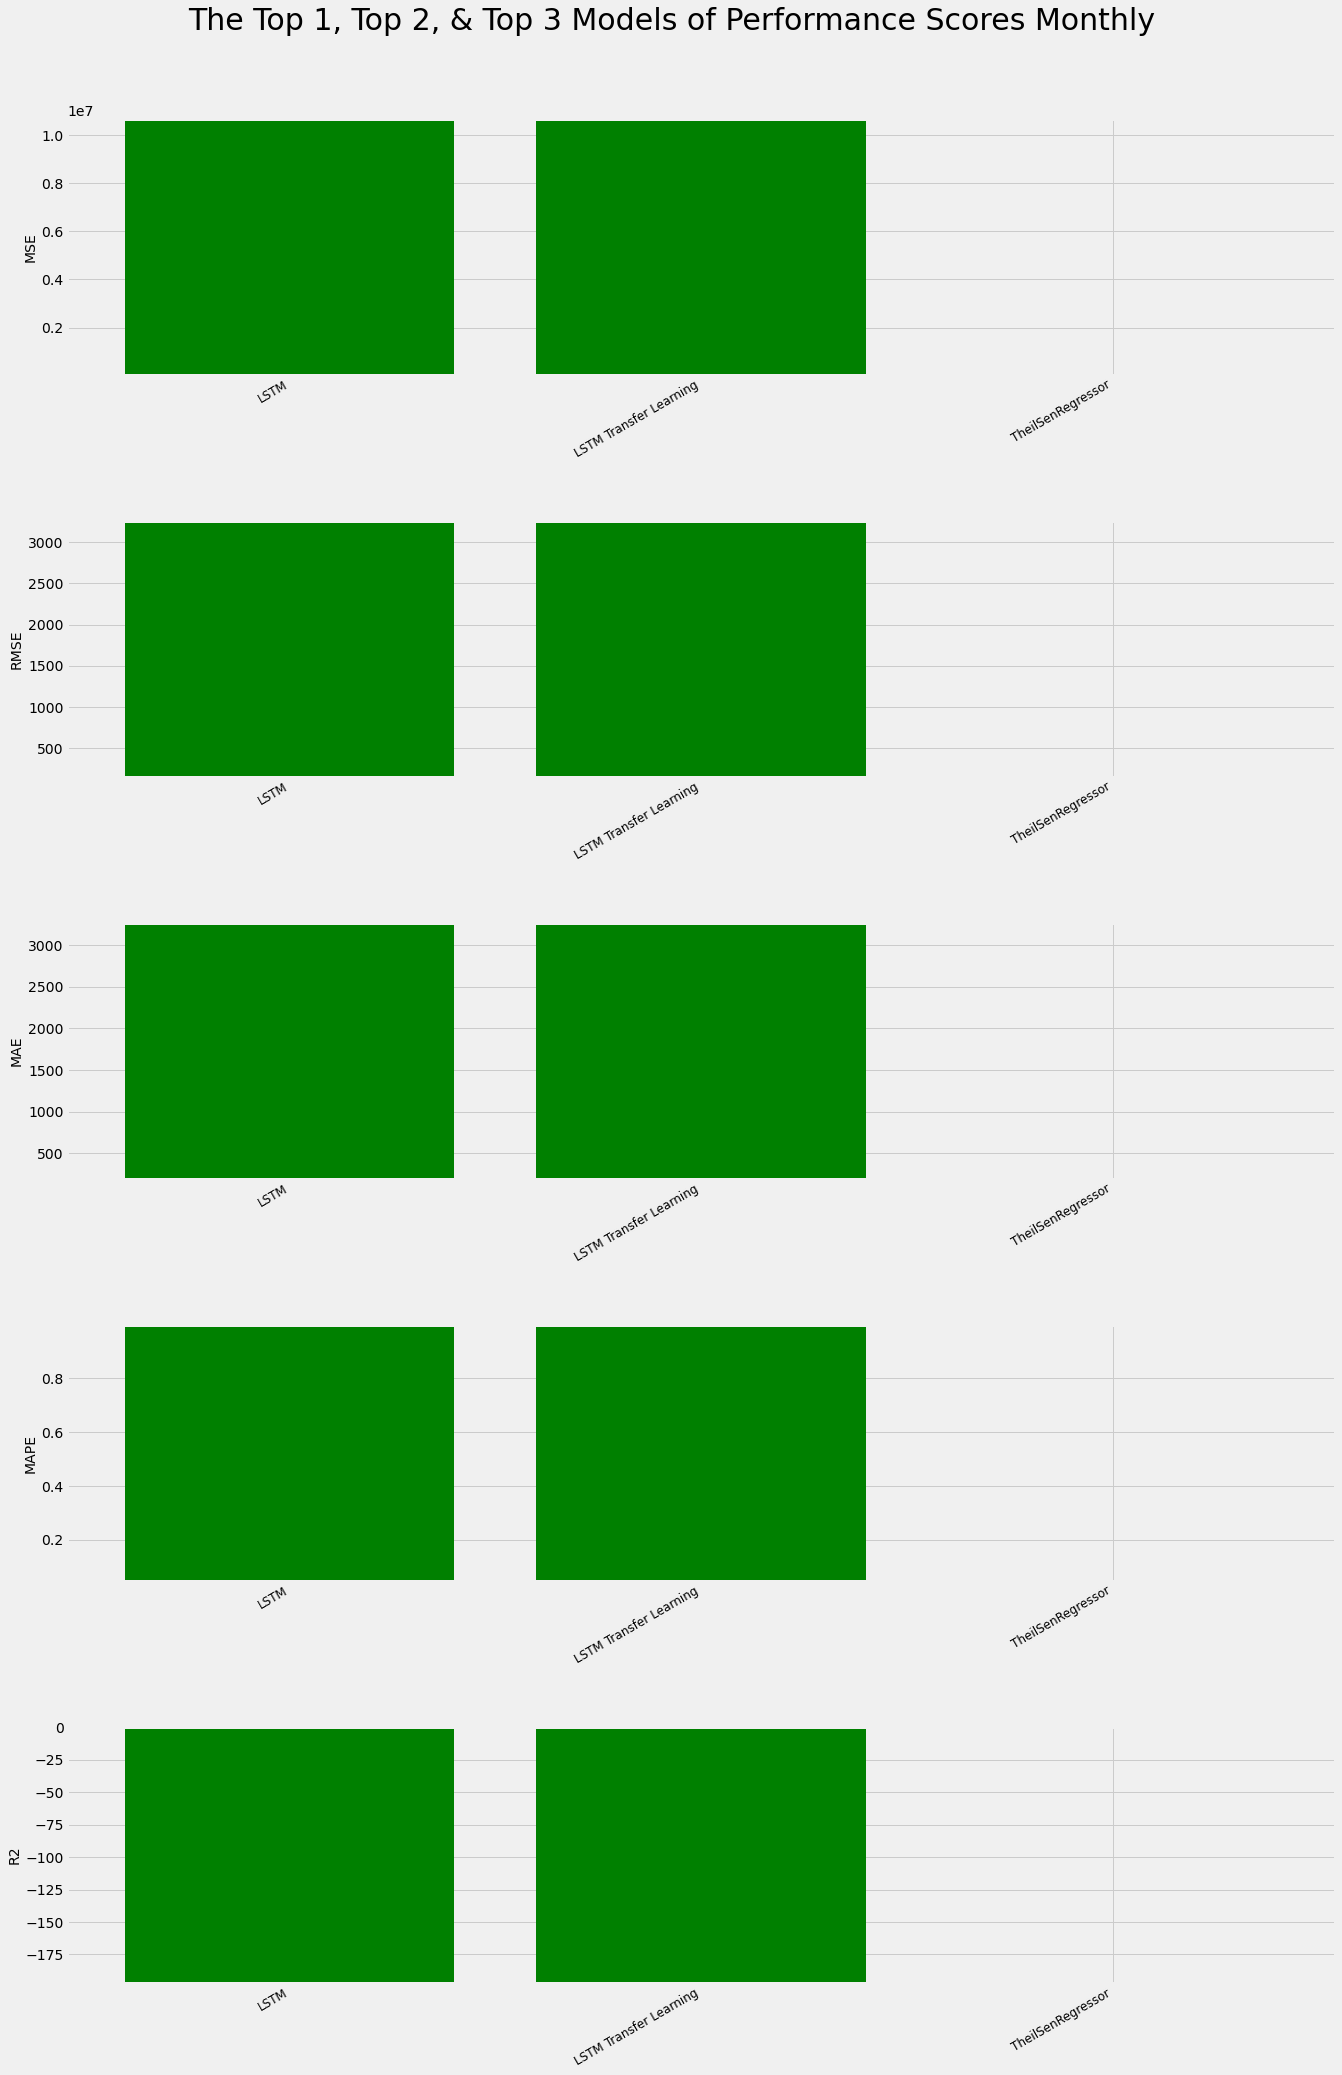

In [34]:
# Read the combined CSV file
df = pd.read_csv('combined_monthly_train_test_sets.csv')

# Get the names of the models
model_names = df.columns[1:]

# Get the maximum scores for each model across all performance metrics
max_scores = df.select_dtypes(include=[float]).loc[:, model_names].max()

# Sort the models by their maximum score in descending order and select the top 3 models
top_models = max_scores.sort_values(ascending=False).head(3).index.tolist()

# Set the x-axis labels to the top 3 models
x_labels = sorted(top_models)

# Get the mean scores for each model and performance metric for the top 3 models
mse_scores = df.select_dtypes(include=[float]).iloc[0].loc[x_labels].tolist()
rmse_scores = df.select_dtypes(include=[float]).iloc[1].loc[x_labels].tolist()
mae_scores = df.select_dtypes(include=[float]).iloc[2].loc[x_labels].tolist()
mape_scores = df.select_dtypes(include=[float]).iloc[3].loc[x_labels].tolist()
r2_scores = df.select_dtypes(include=[float]).iloc[4].loc[x_labels].tolist()

# Set the y-axis labels and scores
y_labels = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R2']
y_scores = [mse_scores, rmse_scores, mae_scores, mape_scores, r2_scores]

# Define available colors
colors = ['green', 'darkolivegreen', 'darkslategray', 'mediumseagreen', 'yellowgreen']

# Generate random color for each bar
bar_colors = [random.choice(colors) for a in range(len(x_labels))]

# Create a bar plot for each score
fig, axs = plt.subplots(nrows=5, figsize=(20, 30))

for i, (label, score) in enumerate(zip(y_labels, y_scores)):
    axs[i].bar(x_labels, score, color=bar_colors)
    axs[i].set_xticklabels((x_labels), rotation=30, ha='right', fontsize=12)
    axs[i].set_ylabel(label, fontsize=14)
    axs[i].set_ylim(min(score), max(score))  # Set the y-axis limits

plt.subplots_adjust(hspace=0.5)
plt.suptitle('The Top 1, Top 2, & Top 3 Models of Performance Scores Monthly', fontsize=30)
plt.tight_layout(pad=4)

# Create a dataframe to store the performance scores
performance = pd.DataFrame(y_scores, columns=x_labels, index=y_labels)

# Get the top 3 models for each metric
performance_sorted = performance.T.sort_values(['MSE', 'RMSE', 'MAE', 'MAPE', 'R2'])
print(performance_sorted)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data_frame = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False)

# Define a function to convert time range to numerical value
def convert_time_hour(time_range):
    if time_range == 'Time Not Stated':
        return -1  # Assign a specific value for 'Time Not Stated'
    else:
        return int(time_range.split('-')[0].split(':')[0])

# Apply the function to convert 'Time Hour' column
data_frame['Time Hour'] = data_frame['Time Hour'].apply(convert_time_hour)

# Split the data into features (X) and target variable (y)
X = data_frame.drop('Time Hour', axis=1)
y = data_frame['Time Hour']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Create an instance of TheilSenRegressor
model = TheilSenRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'max_subpopulation': [1e4, 1e5, 1e6],
    'n_subsamples': [None, 50, 100],
    'max_iter': [50, 100, 200, 500],
    'tol': [1e-5, 1e-4, 1e-3],
}

# Create GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_imputed, y_train)

# Access the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Retrieve the best model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE score on test data: {mse}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import TheilSenRegressor
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data_frame = pd.read_csv('./data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Month per case basis .csv', index_col=False)

# Encode the month names into numerical values
label_encoder = LabelEncoder()
data_frame['Month'] = label_encoder.fit_transform(data_frame['Month'])

# Split the data into features (X) and target variable (y)
X = data_frame.drop('Month', axis=1)
y = data_frame['Month']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Create an instance of TheilSenRegressor
model = TheilSenRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'max_subpopulation': [1e4, 1e5, 1e6],
    'n_subsamples': [None, 50, 100],
    'max_iter': [50, 100, 200, 500],
    'tol': [1e-5, 1e-4, 1e-3],
}

# Create GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_imputed, y_train)

# Access the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Retrieve the best model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test_imputed)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE score on test data: {mse}")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import TheilSenRegressor
from sklearn import metrics
import numpy as np

# Load the dataset from a CSV file
data_frame = pd.read_csv('./data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False)

# Define a function to convert time range to numerical value
def convert_time_hour(time_range):
    if time_range == 'Time Not Stated':
        return -1  # Assign a specific value for 'Time Not Stated'
    else:
        return int(time_range.split('-')[0].split(':')[0])

# Apply the function to convert 'Time Hour' column
data_frame['Time Hour'] = data_frame['Time Hour'].apply(convert_time_hour)

# Split the data into features (X) and target variable (y)
X = data_frame.drop('Time Hour', axis=1)
y = data_frame['Time Hour']

# Handle missing values with mean imputation
X = X.fillna(X.mean())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the TheilSenRegressor model
model = TheilSenRegressor()
param_grid = {
    'fit_intercept': [True, False],
    'max_subpopulation': [1e4],
    'n_subsamples': [50],
    'max_iter': [100],
    'tol': [1e-4],
}

model = GridSearchCV(model, param_grid, cv=KFold(n_splits=5))
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_hour = model.predict(X_test)

# Calculate evaluation metrics
explained_variance = metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
median_absolute_error = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print(f"--------------{model}--------------")
print('explained_variance:', round(explained_variance, 4))
print('r2:', round(r2, 4))
print('MAE:', round(mean_absolute_error, 4))
print('MSE:', round(mse, 4))
print('RMSE:', round(np.sqrt(mse), 4))
print('MAPE:', mape)
print("")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import TheilSenRegressor
from sklearn import metrics
import numpy as np

# Load the data from the CSV file
data_frame = pd.read_csv('./data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Month per case basis .csv', index_col=False)

# Encode the month names into numerical values
label_encoder = LabelEncoder()
data_frame['Month'] = label_encoder.fit_transform(data_frame['Month'])

# Split the data into features (X) and target variable (y)
X = data_frame.drop('Month', axis=1)
y = data_frame['Month']

# Handle missing values with mean imputation
X = X.fillna(X.mean())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the TheilSenRegressor model
model = TheilSenRegressor()
param_grid = {
    'fit_intercept': [True],
    'max_subpopulation': [1e4],
    'n_subsamples': [None],
    'max_iter': [50],
    'tol': [1e-4],
}

model = GridSearchCV(model, param_grid, cv=KFold(n_splits=5))
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_month = model.predict(X_test)

# Calculate evaluation metrics
explained_variance = metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
median_absolute_error = metrics.median_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)

print(f"--------------{model}--------------")
print('explained_variance:', round(explained_variance, 4))
print('r2:', round(r2, 4))
print('MAE:', round(mean_absolute_error, 4))
print('MSE:', round(mse, 4))
print('RMSE:', round(np.sqrt(mse), 4))
print('MAPE:', mape)
print("")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_frame = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False)

train_data = data[data['Time Hour'] == 'train']
test_data = data[data['Time Hour'] == 'test']

plt.scatter(train_data['year'], train_data['time_hour'], label='Train data')
plt.scatter(test_data['year'], test_data['time_hour'], label='Test data')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Time Hour')
plt.title('Train and Test Data')
plt.show()
